In [1]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [2]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [3]:
def preprocess(df, year):
    df[['Env', 'Hybrid']] = df['id'].str.split(':', expand=True)
    df['Env'] += "_" + str(year)
    df = df.drop('id', axis=1).set_index(['Env', 'Hybrid'])
    return df

In [4]:
%%time

ytrain = pd.read_csv('../output/ytrain.csv').set_index(['Env', 'Hybrid'])
xtrain = pd.read_parquet('../output/kronecker_epi_AA_train.parquet')
xtrain = preprocess(xtrain, year=2020)
xtrain = xtrain.merge(ytrain, on=['Env', 'Hybrid'], how='inner')
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']

yval = pd.read_csv('../output/yval.csv').set_index(['Env', 'Hybrid'])
xval = pd.read_parquet('../output/kronecker_epi_AA_val.parquet')
xval = preprocess(xval, year=2021)
xval = xval.merge(yval, on=['Env', 'Hybrid'], how='inner')
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

CPU times: user 14min 36s, sys: 3min 2s, total: 17min 38s
Wall time: 17min 45s


In [5]:
xtrain

weather_station_lat.2369.DK3IIH6  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                                   0.026453   
          B14A/MO17                                  0.178596   
          B14A/OH43                                  0.031022   
          B37/H95                                    0.462462   
          B37/MO17                                   0.869933   
...                                                       ...   
WIH3_2020 W10004_1123/PHP02                          1.152961   
          W10004_1140/PHP02                          0.868290   
          W10004_1143/PHP02                          0.354637   
          W10004_1146/PHP02                          0.956150   
          W10004_1156/PHP02                          1.157501   

                             weather_station_lat.2369.PHN82  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.087934   
          B14A/MO17                                0.179007   
          B14A/OH43                                0.190380   
          B37/H95                                  0.775128   
          B37/MO17                                 1.009929   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        2.306053   
          W10004_1140/PHP02                        1.812642   
          W10004_1143/PHP02                        0.942718   
          W10004_1146/PHP02                        1.748118   
          W10004_1156/PHP02                        2.466025   

                             weather_station_lat.2369.PHZ51  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.067150   
          B14A/MO17                                0.024634   
          B14A/OH43                                0.133505   
          B37/H95                                  0.647440   
          B37/MO17                                 0.489978   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        0.852553   
          W10004_1140/PHP02                        0.646537   
          W10004_1143/PHP02                        1.325811   
          W10004_1146/PHP02                        0.680707   
          W10004_1156/PHP02                        0.614239   

                             weather_station_lat.2FACC.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.011281   
          B14A/MO17                                   0.024201   
          B14A/OH43                                   0.009357   
          B37/H95                                     0.103428   
          B37/MO17                                    0.135003   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           3.195444   
          W10004_1140/PHP02                           1.756443   
          W10004_1143/PHP02                           1.915482   
          W10004_1146/PHP02                           2.154864   
          W10004_1156/PHP02                           2.358873   

                             weather_station_lat.4N506.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.010385   
          B14A/MO17                                   0.000455   
          B14A/OH43                                   0.004669   
          B37/H95                                     0.240375   
          B37/MO17                                    0.368954   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           1.348529   
          W10004_1140/PHP02                           1.183893   
          W10004_1143/PH

### Training

In [6]:
# %%time

# NCOLS = xtrain.shape[1]
# print('features:', NCOLS)

# best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
#                'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
#                'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
# model = lgbm.LGBMRegressor(random_state=42, **best_params)
# model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# # predict
# ypred = model.predict(xval.iloc[:, :NCOLS])

# # validate
# df_eval = pd.DataFrame()
# df_eval['Env'] = xval.index.get_level_values(0)
# df_eval['ytrue'] = list(yval)
# df_eval['ypred'] = ypred
# rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# print(rmse_per_group)

# rmse = sum(rmse_per_group) / len(rmse_per_group)
# print('RMSE:', rmse)

In [7]:
# print(r2_score(df_eval['ytrue'], df_eval['ypred']))
# df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [8]:
from sklearn.decomposition import TruncatedSVD

In [9]:
%%time

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.9782664531817062
CPU times: user 5min 19s, sys: 8.91 s, total: 5min 28s
Wall time: 5min 30s


In [10]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

CPU times: user 57.2 s, sys: 0 ns, total: 57.2 s
Wall time: 57.4 s


In [11]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [12]:
xtrain_svd

kron_svd0     kron_svd1     kron_svd2  \
Env       Hybrid                                                       
DEH1_2020 B14A/H95            248.428264    149.167739     79.799394   
          B14A/MO17           638.149632    584.405947    216.185018   
          B14A/OH43           567.602872    383.618623    186.930410   
          B37/H95             719.284799    476.099962    363.415321   
          B37/MO17            894.008467    885.796111    562.104276   
...                                  ...           ...           ...   
WIH3_2020 W10004_1123/PHP02  4584.873861  12182.369842  16527.959222   
          W10004_1140/PHP02  3506.258688   9164.939005  12496.252357   
          W10004_1143/PHP02  3709.267697   8855.131751  12128.246864   
          W10004_1146/PHP02  3600.997037   9448.454265  13008.477725   
          W10004_1156/PHP02  3794.735789   9517.072792  12932.436781   

                               kron_svd3    kron_svd4     kron_svd5  \
Env       Hybrid                                                      
DEH1_2020 B14A/H95            -56.389536     3.594933      6.172149   
          B14A/MO17          -131.496066     9.219688     16.920591   
          B14A/OH43          -124.597997     7.300475      9.285236   
          B37/H95            -165.607471    11.818149     22.535203   
          B37/MO17           -176.724837    13.141619     21.942044   
...                                  ...          ...           ...   
WIH3_2020 W10004_1123/PHP02  1465.142403  1515.911143  16787.558879   
          W10004_1140/PHP02  1120.508986  1148.545094  12672.272342   
          W10004_1143/PHP02  1174.576683  1147.953899  12329.087544   
          W10004_1146/PHP02  1151.501121  1188.028106  13142.737962   
          W10004_1156/PHP02  1208.340342  1207.376630  13154.038560   

                               kron_svd6   kron_svd7    kron_svd8  \
Env       Hybrid                                                    
DEH1_2020 B14A/H95           1069.873203   47.179482    58.400633   
          B14A/MO17          3652.182661  174.967552    53.726021   
          B14A/OH43          1745.796884  126.204907     7.715540   
          B37/H95            3280.430526  -89.958126  1374.731687   
          B37/MO17           4588.510080   96.372239   711.477869   
...                                  ...         ...          ...   
WIH3_2020 W10004_1123/PHP02   -72.405282 -229.625439  -210.223591   
          W10004_1140/PHP02  -507.134788 -195.481007   -94.174181   
          W10004_1143/PHP02   479.047062 -206.822794   174.587045   
          W10004_1146/PHP02  -404.921562 -217.398508  -148.085786   
          W10004_1156/PHP02  -381.504936 -187.131855   -71.067194   

                               kron_svd9  ...  kron_svd96  kron_svd97  \
Env       Hybrid                          ...                           
DEH1_2020 B14A/H95            132.148025  ...  -50.847670   23.826594   
          B14A/MO17           277.684811  ...  290.686345   98.492887   
          B14A/OH43           142.361136  ...   64.499716  133.131111   
          B37/H95            1612.072416  ...  -54.895246   69.231868   
          B37/MO17            981.860810  ... -286.172022  181.650400   
...                                  ...  ...         ...         ...   
WIH3_2020 W10004_1123/PHP02  -397.006221  ...  -20.314737  162.705626   
          W10004_1140/PHP02  -233.091339  ... -201.846281  -88.584807   
          W10004_1143/PHP02   120.513657  ...  104.983134   87.709470   
          W10004_1146/PHP02  -269.070637  ...  160.296514 -183.964563   
          W10004_1156/PHP02  -201.716201  ...  -60.827262   19.092241   

                             kron_svd98  kron_svd99  mean_yield_lag_2  \
Env       Hybrid                                                        
DEH1_2020 B14A/H95            -0.407108 -199.852156         10.056423   
          B14A/MO17          124.281667  -34.938361         10.056423   
          B14A/OH43          1

In [13]:
import optuna

In [14]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-02-01 15:43:27,896] A new study created in memory with name: no-name-e32300ce-7ca6-40ec-bf39-c99304aad4e3


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.839196365086843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839196365086843
[LightGBM] [Warning] feature_fraction is set=0.3745401188473625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745401188473625
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-02-01 15:43:28,308] Trial 0 finished with value: 2.312053627107654 and parameters: {'feature_fraction': 0.3745401188473625, 'num_leaves': 244, 'bagging_fraction': 0.839196365086843, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.312053627107654.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.8248435466776274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8248435466776274
[LightGBM] [Warning] feature_fraction is set=0.8661761457749352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661761457749352
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-02-01 15:43:29,631] Trial 1 finished with value: 2.2400657735450116 and parameters: {'feature_fraction': 0.8661761457749352, 'num_leaves': 155, 'bagging_fraction': 0.8248435466776274, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.2400657735450116.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.5825453457757226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5825453457757226
[LightGBM] [Warning] feature_fraction is set=0.18182496720710062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18182496720710062
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-02-01 15:43:30,166] Trial 2 finished with value: 2.234980163433654 and parameters: {'feature_fraction': 0.18182496720710062, 'num_leaves': 48, 'bagging_fraction': 0.5825453457757226, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 2 with value: 2.234980163433654.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] feature_fraction is set=0.13949386065204183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13949386065204183
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-02-01 15:43:30,546] Trial 3 finished with value: 2.251969093898755 and parameters: {'feature_fraction': 0.13949386065204183, 'num_leaves': 76, 'bagging_fraction': 0.619817105976215, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 2 with value: 2.234980163433654.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.764526911140863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764526911140863
[LightGBM] [Warning] feature_fraction is set=0.5924145688620425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924145688620425
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-02-01 15:43:32,226] Trial 4 finished with value: 2.2448164573095872 and parameters: {'feature_fraction': 0.5924145688620425, 'num_leaves': 13, 'bagging_fraction': 0.764526911140863, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 2 with value: 2.234980163433654.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] feature_fraction is set=0.8083973481164611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083973481164611
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-02-01 15:43:32,772] Trial 5 finished with value: 2.2483254922982474 and parameters: {'feature_fraction': 0.8083973481164611, 'num_leaves': 79, 'bagging_fraction': 0.45860326840383037, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 2 with value: 2.234980163433654.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.5552679889600102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552679889600102
[LightGBM] [Warning] feature_fraction is set=0.034388521115218396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.034388521115218396
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-02-01 15:43:33,221] Trial 6 finished with value: 2.2312042136747205 and parameters: {'feature_fraction': 0.034388521115218396, 'num_leaves': 233, 'bagging_fraction': 0.5552679889600102, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8650796940166687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8650796940166687
[LightGBM] [Warning] feature_fraction is set=0.18485445552552704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18485445552552704
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-02-01 15:43:34,260] Trial 7 finished with value: 2.2506978971906366 and parameters: {'feature_fraction': 0.18485445552552704, 'num_leaves': 249, 'bagging_fraction': 0.8650796940166687, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.4271363733463229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4271363733463229
[LightGBM] [Warning] feature_fraction is set=0.0884925020519195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884925020519195
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-02-01 15:43:34,759] Trial 8 finished with value: 2.2619259601073787 and parameters: {'feature_fraction': 0.0884925020519195, 'num_leaves': 51, 'bagging_fraction': 0.4271363733463229, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.7256176498949491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256176498949491
[LightGBM] [Warning] feature_fraction is set=0.3567533266935893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567533266935893
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-02-01 15:43:35,259] Trial 9 finished with value: 2.296328537219854 and parameters: {'feature_fraction': 0.3567533266935893, 'num_leaves': 73, 'bagging_fraction': 0.7256176498949491, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=0.19237494135966834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19237494135966834
[LightGBM] [Warning] bagging_fraction is set=0.9817222664727197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817222664727197
[LightGBM] [Warning] feature_fraction is set=0.02051392850324301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02051392850324301
[LightGBM] [Warning] lambda_l2 is set=6.739006603244534e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.739006603244534e-07


[I 2023-02-01 15:43:35,684] Trial 10 finished with value: 2.2855148511454986 and parameters: {'feature_fraction': 0.02051392850324301, 'num_leaves': 182, 'bagging_fraction': 0.9817222664727197, 'lambda_l1': 0.19237494135966834, 'lambda_l2': 6.739006603244534e-07, 'n_estimators': 167, 'max_depth': 3}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=0.0001775837876601946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001775837876601946
[LightGBM] [Warning] bagging_fraction is set=0.590940097979374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.590940097979374
[LightGBM] [Warning] feature_fraction is set=0.012038945108446442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012038945108446442
[LightGBM] [Warning] lambda_l2 is set=0.002441003375923454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002441003375923454


[I 2023-02-01 15:43:36,115] Trial 11 finished with value: 2.384480063095552 and parameters: {'feature_fraction': 0.012038945108446442, 'num_leaves': 191, 'bagging_fraction': 0.590940097979374, 'lambda_l1': 0.0001775837876601946, 'lambda_l2': 0.002441003375923454, 'n_estimators': 119, 'max_depth': 5}. Best is trial 6 with value: 2.2312042136747205.


[LightGBM] [Warning] lambda_l1 is set=0.011384113693111311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011384113693111311
[LightGBM] [Warning] bagging_fraction is set=0.5853183069331859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853183069331859
[LightGBM] [Warning] feature_fraction is set=0.24337902263420905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24337902263420905
[LightGBM] [Warning] lambda_l2 is set=4.7844631871840646e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7844631871840646e-06


[I 2023-02-01 15:43:37,084] Trial 12 finished with value: 2.205852110458948 and parameters: {'feature_fraction': 0.24337902263420905, 'num_leaves': 128, 'bagging_fraction': 0.5853183069331859, 'lambda_l1': 0.011384113693111311, 'lambda_l2': 4.7844631871840646e-06, 'n_estimators': 198, 'max_depth': 5}. Best is trial 12 with value: 2.205852110458948.


[LightGBM] [Warning] lambda_l1 is set=0.05802878748880696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05802878748880696
[LightGBM] [Warning] bagging_fraction is set=0.5057379395903193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5057379395903193
[LightGBM] [Warning] feature_fraction is set=0.2906046747005957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2906046747005957
[LightGBM] [Warning] lambda_l2 is set=3.817371339337113e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.817371339337113e-06


[I 2023-02-01 15:43:38,166] Trial 13 finished with value: 2.1790036933846966 and parameters: {'feature_fraction': 0.2906046747005957, 'num_leaves': 123, 'bagging_fraction': 0.5057379395903193, 'lambda_l1': 0.05802878748880696, 'lambda_l2': 3.817371339337113e-06, 'n_estimators': 202, 'max_depth': 5}. Best is trial 13 with value: 2.1790036933846966.


[LightGBM] [Warning] lambda_l1 is set=0.22103573192536188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22103573192536188
[LightGBM] [Warning] bagging_fraction is set=0.5007799535158548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007799535158548
[LightGBM] [Warning] feature_fraction is set=0.2982895788017856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2982895788017856
[LightGBM] [Warning] lambda_l2 is set=2.4713782011860853e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4713782011860853e-06


[I 2023-02-01 15:43:39,352] Trial 14 finished with value: 2.1752111008315373 and parameters: {'feature_fraction': 0.2982895788017856, 'num_leaves': 122, 'bagging_fraction': 0.5007799535158548, 'lambda_l1': 0.22103573192536188, 'lambda_l2': 2.4713782011860853e-06, 'n_estimators': 218, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=8.20525711911934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.20525711911934
[LightGBM] [Warning] bagging_fraction is set=0.49025940150133107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49025940150133107
[LightGBM] [Warning] feature_fraction is set=0.5125858318483725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5125858318483725
[LightGBM] [Warning] lambda_l2 is set=1.106407839959724e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.106407839959724e-08


[I 2023-02-01 15:43:41,184] Trial 15 finished with value: 2.2512116729103924 and parameters: {'feature_fraction': 0.5125858318483725, 'num_leaves': 120, 'bagging_fraction': 0.49025940150133107, 'lambda_l1': 8.20525711911934, 'lambda_l2': 1.106407839959724e-08, 'n_estimators': 229, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.2283879320694494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2283879320694494
[LightGBM] [Warning] bagging_fraction is set=0.5014620828272766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5014620828272766
[LightGBM] [Warning] feature_fraction is set=0.3131688761183301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3131688761183301
[LightGBM] [Warning] lambda_l2 is set=0.0008336561698046581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008336561698046581


[I 2023-02-01 15:43:42,399] Trial 16 finished with value: 2.2123718814277034 and parameters: {'feature_fraction': 0.3131688761183301, 'num_leaves': 103, 'bagging_fraction': 0.5014620828272766, 'lambda_l1': 0.2283879320694494, 'lambda_l2': 0.0008336561698046581, 'n_estimators': 224, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.27410262472733826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27410262472733826
[LightGBM] [Warning] bagging_fraction is set=0.6516296683967093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6516296683967093
[LightGBM] [Warning] feature_fraction is set=0.4400604138607652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4400604138607652
[LightGBM] [Warning] lambda_l2 is set=8.513482595785166e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.513482595785166e-07


[I 2023-02-01 15:43:43,422] Trial 17 finished with value: 2.202122557264827 and parameters: {'feature_fraction': 0.4400604138607652, 'num_leaves': 167, 'bagging_fraction': 0.6516296683967093, 'lambda_l1': 0.27410262472733826, 'lambda_l2': 8.513482595785166e-07, 'n_estimators': 288, 'max_depth': 3}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.9771702525675117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9771702525675117
[LightGBM] [Warning] bagging_fraction is set=0.4031664351817183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4031664351817183
[LightGBM] [Warning] feature_fraction is set=0.26304355633915394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26304355633915394
[LightGBM] [Warning] lambda_l2 is set=6.254675419090565e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.254675419090565e-06


[I 2023-02-01 15:43:44,034] Trial 18 finished with value: 2.2316285949083783 and parameters: {'feature_fraction': 0.26304355633915394, 'num_leaves': 205, 'bagging_fraction': 0.4031664351817183, 'lambda_l1': 0.9771702525675117, 'lambda_l2': 6.254675419090565e-06, 'n_estimators': 123, 'max_depth': 4}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.08388729678327497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08388729678327497
[LightGBM] [Warning] bagging_fraction is set=0.5309097161823206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5309097161823206
[LightGBM] [Warning] feature_fraction is set=0.5996408444196241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5996408444196241
[LightGBM] [Warning] lambda_l2 is set=9.675818032976536e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.675818032976536e-08


[I 2023-02-01 15:43:45,806] Trial 19 finished with value: 2.2531837684211395 and parameters: {'feature_fraction': 0.5996408444196241, 'num_leaves': 151, 'bagging_fraction': 0.5309097161823206, 'lambda_l1': 0.08388729678327497, 'lambda_l2': 9.675818032976536e-08, 'n_estimators': 216, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=1.3110970299009215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3110970299009215
[LightGBM] [Warning] bagging_fraction is set=0.5070144485386008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5070144485386008
[LightGBM] [Warning] feature_fraction is set=0.2567069389694278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2567069389694278
[LightGBM] [Warning] lambda_l2 is set=1.378075110436795e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.378075110436795e-06


[I 2023-02-01 15:43:46,764] Trial 20 finished with value: 2.218195658131233 and parameters: {'feature_fraction': 0.2567069389694278, 'num_leaves': 103, 'bagging_fraction': 0.5070144485386008, 'lambda_l1': 1.3110970299009215, 'lambda_l2': 1.378075110436795e-06, 'n_estimators': 262, 'max_depth': 4}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.08847234457165422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08847234457165422
[LightGBM] [Warning] bagging_fraction is set=0.649949504745993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.649949504745993
[LightGBM] [Warning] feature_fraction is set=0.42857654162621833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42857654162621833
[LightGBM] [Warning] lambda_l2 is set=6.980902948832612e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.980902948832612e-07


[I 2023-02-01 15:43:47,781] Trial 21 finished with value: 2.1964686486998115 and parameters: {'feature_fraction': 0.42857654162621833, 'num_leaves': 166, 'bagging_fraction': 0.649949504745993, 'lambda_l1': 0.08847234457165422, 'lambda_l2': 6.980902948832612e-07, 'n_estimators': 298, 'max_depth': 3}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.04484713438032796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04484713438032796
[LightGBM] [Warning] bagging_fraction is set=0.6610626673089052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6610626673089052
[LightGBM] [Warning] feature_fraction is set=0.4318577859996767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4318577859996767
[LightGBM] [Warning] lambda_l2 is set=8.430146188689356e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.430146188689356e-08


[I 2023-02-01 15:43:48,495] Trial 22 finished with value: 2.219481296200286 and parameters: {'feature_fraction': 0.4318577859996767, 'num_leaves': 145, 'bagging_fraction': 0.6610626673089052, 'lambda_l1': 0.04484713438032796, 'lambda_l2': 8.430146188689356e-08, 'n_estimators': 257, 'max_depth': 2}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=9.487188521013676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.487188521013676
[LightGBM] [Warning] bagging_fraction is set=0.4562188435141983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4562188435141983
[LightGBM] [Warning] feature_fraction is set=0.36097742761400625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36097742761400625
[LightGBM] [Warning] lambda_l2 is set=4.286462166759075e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.286462166759075e-07


[I 2023-02-01 15:43:49,075] Trial 23 finished with value: 2.2200407848146724 and parameters: {'feature_fraction': 0.36097742761400625, 'num_leaves': 215, 'bagging_fraction': 0.4562188435141983, 'lambda_l1': 9.487188521013676, 'lambda_l2': 4.286462166759075e-07, 'n_estimators': 134, 'max_depth': 3}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.7818172154414398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7818172154414398
[LightGBM] [Warning] bagging_fraction is set=0.5612753379703167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5612753379703167
[LightGBM] [Warning] feature_fraction is set=0.28279212568172696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28279212568172696
[LightGBM] [Warning] lambda_l2 is set=1.7139845784367804e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7139845784367804e-05


[I 2023-02-01 15:43:49,902] Trial 24 finished with value: 2.199742208747141 and parameters: {'feature_fraction': 0.28279212568172696, 'num_leaves': 112, 'bagging_fraction': 0.5612753379703167, 'lambda_l1': 0.7818172154414398, 'lambda_l2': 1.7139845784367804e-05, 'n_estimators': 198, 'max_depth': 4}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.04200859570969317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04200859570969317
[LightGBM] [Warning] bagging_fraction is set=0.5191572490783045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5191572490783045
[LightGBM] [Warning] feature_fraction is set=0.5047142760952016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5047142760952016
[LightGBM] [Warning] lambda_l2 is set=3.0456799057403425e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0456799057403425e-06


[I 2023-02-01 15:43:50,743] Trial 25 finished with value: 2.220460418226086 and parameters: {'feature_fraction': 0.5047142760952016, 'num_leaves': 140, 'bagging_fraction': 0.5191572490783045, 'lambda_l1': 0.04200859570969317, 'lambda_l2': 3.0456799057403425e-06, 'n_estimators': 300, 'max_depth': 2}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.0030881952939905755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030881952939905755
[LightGBM] [Warning] bagging_fraction is set=0.45675718101073476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45675718101073476
[LightGBM] [Warning] feature_fraction is set=0.18721036848716585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18721036848716585
[LightGBM] [Warning] lambda_l2 is set=1.9676523765986512e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9676523765986512e-07


[I 2023-02-01 15:43:51,389] Trial 26 finished with value: 2.220849225037716 and parameters: {'feature_fraction': 0.18721036848716585, 'num_leaves': 174, 'bagging_fraction': 0.45675718101073476, 'lambda_l1': 0.0030881952939905755, 'lambda_l2': 1.9676523765986512e-07, 'n_estimators': 245, 'max_depth': 3}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.3403589232848064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3403589232848064
[LightGBM] [Warning] bagging_fraction is set=0.6425768918029743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6425768918029743
[LightGBM] [Warning] feature_fraction is set=0.41046354913652605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41046354913652605
[LightGBM] [Warning] lambda_l2 is set=1.3994422540820528e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3994422540820528e-06


[I 2023-02-01 15:43:52,715] Trial 27 finished with value: 2.2532019854189036 and parameters: {'feature_fraction': 0.41046354913652605, 'num_leaves': 91, 'bagging_fraction': 0.6425768918029743, 'lambda_l1': 0.3403589232848064, 'lambda_l2': 1.3994422540820528e-06, 'n_estimators': 201, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.028638712715127235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028638712715127235
[LightGBM] [Warning] bagging_fraction is set=0.6886784527195214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886784527195214
[LightGBM] [Warning] feature_fraction is set=0.3336701878087538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3336701878087538
[LightGBM] [Warning] lambda_l2 is set=2.412436560797139e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.412436560797139e-08


[I 2023-02-01 15:43:54,600] Trial 28 finished with value: 2.270387602230864 and parameters: {'feature_fraction': 0.3336701878087538, 'num_leaves': 128, 'bagging_fraction': 0.6886784527195214, 'lambda_l1': 0.028638712715127235, 'lambda_l2': 2.412436560797139e-08, 'n_estimators': 274, 'max_depth': 6}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.0030636882704645515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030636882704645515
[LightGBM] [Warning] bagging_fraction is set=0.6135724796890734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6135724796890734
[LightGBM] [Warning] feature_fraction is set=0.38992563832047555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38992563832047555
[LightGBM] [Warning] lambda_l2 is set=2.0278396720593865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0278396720593865e-07


[I 2023-02-01 15:43:55,253] Trial 29 finished with value: 2.24010326466145 and parameters: {'feature_fraction': 0.38992563832047555, 'num_leaves': 198, 'bagging_fraction': 0.6135724796890734, 'lambda_l1': 0.0030636882704645515, 'lambda_l2': 2.0278396720593865e-07, 'n_estimators': 238, 'max_depth': 2}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.09450407986218534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09450407986218534
[LightGBM] [Warning] bagging_fraction is set=0.541317007935256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541317007935256
[LightGBM] [Warning] feature_fraction is set=0.3110461653323451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3110461653323451
[LightGBM] [Warning] lambda_l2 is set=1.3598552111536128e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3598552111536128e-07


[I 2023-02-01 15:43:55,574] Trial 30 finished with value: 2.383133402904085 and parameters: {'feature_fraction': 0.3110461653323451, 'num_leaves': 165, 'bagging_fraction': 0.541317007935256, 'lambda_l1': 0.09450407986218534, 'lambda_l2': 1.3598552111536128e-07, 'n_estimators': 10, 'max_depth': 4}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.9024731676446582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9024731676446582
[LightGBM] [Warning] bagging_fraction is set=0.5684325701518731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5684325701518731
[LightGBM] [Warning] feature_fraction is set=0.24753270879786254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24753270879786254
[LightGBM] [Warning] lambda_l2 is set=1.5401711426348656e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5401711426348656e-05


[I 2023-02-01 15:43:56,323] Trial 31 finished with value: 2.2081650910252395 and parameters: {'feature_fraction': 0.24753270879786254, 'num_leaves': 111, 'bagging_fraction': 0.5684325701518731, 'lambda_l1': 0.9024731676446582, 'lambda_l2': 1.5401711426348656e-05, 'n_estimators': 184, 'max_depth': 4}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.6549701489133618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6549701489133618
[LightGBM] [Warning] bagging_fraction is set=0.5486715823634511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486715823634511
[LightGBM] [Warning] feature_fraction is set=0.29664869182024445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29664869182024445
[LightGBM] [Warning] lambda_l2 is set=1.6710740513445283e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6710740513445283e-05


[I 2023-02-01 15:43:57,457] Trial 32 finished with value: 2.201175192526501 and parameters: {'feature_fraction': 0.29664869182024445, 'num_leaves': 140, 'bagging_fraction': 0.5486715823634511, 'lambda_l1': 0.6549701489133618, 'lambda_l2': 1.6710740513445283e-05, 'n_estimators': 210, 'max_depth': 5}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=2.588343149511413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.588343149511413
[LightGBM] [Warning] bagging_fraction is set=0.6033342295313807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6033342295313807
[LightGBM] [Warning] feature_fraction is set=0.1351828377613874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1351828377613874
[LightGBM] [Warning] lambda_l2 is set=7.764381962196771e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.764381962196771e-05


[I 2023-02-01 15:43:57,956] Trial 33 finished with value: 2.2521257801503656 and parameters: {'feature_fraction': 0.1351828377613874, 'num_leaves': 115, 'bagging_fraction': 0.6033342295313807, 'lambda_l1': 2.588343149511413, 'lambda_l2': 7.764381962196771e-05, 'n_estimators': 143, 'max_depth': 3}. Best is trial 14 with value: 2.1752111008315373.


[LightGBM] [Warning] lambda_l1 is set=0.13037057156871076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13037057156871076
[LightGBM] [Warning] bagging_fraction is set=0.4918441925387113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4918441925387113
[LightGBM] [Warning] feature_fraction is set=0.2124020064200628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2124020064200628
[LightGBM] [Warning] lambda_l2 is set=3.6270531396088828e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6270531396088828e-06


[I 2023-02-01 15:43:58,692] Trial 34 finished with value: 2.14710973821964 and parameters: {'feature_fraction': 0.2124020064200628, 'num_leaves': 95, 'bagging_fraction': 0.4918441925387113, 'lambda_l1': 0.13037057156871076, 'lambda_l2': 3.6270531396088828e-06, 'n_estimators': 195, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.0011554464223796277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011554464223796277
[LightGBM] [Warning] bagging_fraction is set=0.478026222793996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.478026222793996
[LightGBM] [Warning] feature_fraction is set=0.18106576865727908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18106576865727908
[LightGBM] [Warning] lambda_l2 is set=1.1455194823113772e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1455194823113772e-06


[I 2023-02-01 15:43:59,534] Trial 35 finished with value: 2.2328687654739574 and parameters: {'feature_fraction': 0.18106576865727908, 'num_leaves': 57, 'bagging_fraction': 0.478026222793996, 'lambda_l1': 0.0011554464223796277, 'lambda_l2': 1.1455194823113772e-06, 'n_estimators': 178, 'max_depth': 5}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.09222899201815812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09222899201815812
[LightGBM] [Warning] bagging_fraction is set=0.4015772134456509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4015772134456509
[LightGBM] [Warning] feature_fraction is set=0.22692393088499363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22692393088499363
[LightGBM] [Warning] lambda_l2 is set=4.6851331907646217e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6851331907646217e-07


[I 2023-02-01 15:44:00,254] Trial 36 finished with value: 2.2320808804268943 and parameters: {'feature_fraction': 0.22692393088499363, 'num_leaves': 92, 'bagging_fraction': 0.4015772134456509, 'lambda_l1': 0.09222899201815812, 'lambda_l2': 4.6851331907646217e-07, 'n_estimators': 265, 'max_depth': 3}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.012002406390259589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012002406390259589
[LightGBM] [Warning] bagging_fraction is set=0.50258294864195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.50258294864195
[LightGBM] [Warning] feature_fraction is set=0.13740059963707518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13740059963707518
[LightGBM] [Warning] lambda_l2 is set=3.466380872363163e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.466380872363163e-06


[I 2023-02-01 15:44:00,807] Trial 37 finished with value: 2.2112303515980036 and parameters: {'feature_fraction': 0.13740059963707518, 'num_leaves': 156, 'bagging_fraction': 0.50258294864195, 'lambda_l1': 0.012002406390259589, 'lambda_l2': 3.466380872363163e-06, 'n_estimators': 147, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.004760331049369721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004760331049369721
[LightGBM] [Warning] bagging_fraction is set=0.47338925633325457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47338925633325457
[LightGBM] [Warning] feature_fraction is set=0.33835805399319485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33835805399319485
[LightGBM] [Warning] lambda_l2 is set=0.0003228850490747899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003228850490747899


[I 2023-02-01 15:44:01,796] Trial 38 finished with value: 2.202177299311561 and parameters: {'feature_fraction': 0.33835805399319485, 'num_leaves': 28, 'bagging_fraction': 0.47338925633325457, 'lambda_l1': 0.004760331049369721, 'lambda_l2': 0.0003228850490747899, 'n_estimators': 236, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.0006183065113963006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006183065113963006
[LightGBM] [Warning] bagging_fraction is set=0.4353262217074409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4353262217074409
[LightGBM] [Warning] feature_fraction is set=0.09488625931710726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09488625931710726
[LightGBM] [Warning] lambda_l2 is set=4.143638251553394e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.143638251553394e-08


[I 2023-02-01 15:44:02,653] Trial 39 finished with value: 2.2161351797192315 and parameters: {'feature_fraction': 0.09488625931710726, 'num_leaves': 67, 'bagging_fraction': 0.4353262217074409, 'lambda_l1': 0.0006183065113963006, 'lambda_l2': 4.143638251553394e-08, 'n_estimators': 278, 'max_depth': 5}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.026158315230991998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026158315230991998
[LightGBM] [Warning] bagging_fraction is set=0.5296780191431701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5296780191431701
[LightGBM] [Warning] feature_fraction is set=0.47275521193448683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47275521193448683
[LightGBM] [Warning] lambda_l2 is set=2.6203434576342715e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6203434576342715e-06


[I 2023-02-01 15:44:04,147] Trial 40 finished with value: 2.260865325132666 and parameters: {'feature_fraction': 0.47275521193448683, 'num_leaves': 31, 'bagging_fraction': 0.5296780191431701, 'lambda_l1': 0.026158315230991998, 'lambda_l2': 2.6203434576342715e-06, 'n_estimators': 170, 'max_depth': 6}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.15599056272209533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15599056272209533
[LightGBM] [Warning] bagging_fraction is set=0.5640804176215006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5640804176215006
[LightGBM] [Warning] feature_fraction is set=0.29343854854653856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29343854854653856
[LightGBM] [Warning] lambda_l2 is set=2.287349375249889e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.287349375249889e-05


[I 2023-02-01 15:44:04,969] Trial 41 finished with value: 2.1934318452720887 and parameters: {'feature_fraction': 0.29343854854653856, 'num_leaves': 89, 'bagging_fraction': 0.5640804176215006, 'lambda_l1': 0.15599056272209533, 'lambda_l2': 2.287349375249889e-05, 'n_estimators': 192, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.17024940705028624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17024940705028624
[LightGBM] [Warning] bagging_fraction is set=0.576291942115589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.576291942115589
[LightGBM] [Warning] feature_fraction is set=0.37746687963220615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37746687963220615
[LightGBM] [Warning] lambda_l2 is set=4.625882243313798e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.625882243313798e-05


[I 2023-02-01 15:44:05,892] Trial 42 finished with value: 2.2058794893101608 and parameters: {'feature_fraction': 0.37746687963220615, 'num_leaves': 87, 'bagging_fraction': 0.576291942115589, 'lambda_l1': 0.17024940705028624, 'lambda_l2': 4.625882243313798e-05, 'n_estimators': 191, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.060523583555571726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.060523583555571726
[LightGBM] [Warning] bagging_fraction is set=0.6137465141466161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6137465141466161
[LightGBM] [Warning] feature_fraction is set=0.2025243056516179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2025243056516179
[LightGBM] [Warning] lambda_l2 is set=8.379506261121563e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.379506261121563e-06


[I 2023-02-01 15:44:06,581] Trial 43 finished with value: 2.2021068943863744 and parameters: {'feature_fraction': 0.2025243056516179, 'num_leaves': 100, 'bagging_fraction': 0.6137465141466161, 'lambda_l1': 0.060523583555571726, 'lambda_l2': 8.379506261121563e-06, 'n_estimators': 212, 'max_depth': 3}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.023904587031335526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023904587031335526
[LightGBM] [Warning] bagging_fraction is set=0.5301505127509837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5301505127509837
[LightGBM] [Warning] feature_fraction is set=0.315064177467236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.315064177467236
[LightGBM] [Warning] lambda_l2 is set=2.0417332163069483e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0417332163069483e-06


[I 2023-02-01 15:44:07,322] Trial 44 finished with value: 2.201437612541205 and parameters: {'feature_fraction': 0.315064177467236, 'num_leaves': 133, 'bagging_fraction': 0.5301505127509837, 'lambda_l1': 0.023904587031335526, 'lambda_l2': 2.0417332163069483e-06, 'n_estimators': 158, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.007949873275263229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007949873275263229
[LightGBM] [Warning] bagging_fraction is set=0.4896355618172511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4896355618172511
[LightGBM] [Warning] feature_fraction is set=0.2737253299755345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2737253299755345
[LightGBM] [Warning] lambda_l2 is set=5.161629689543506e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.161629689543506e-07


[I 2023-02-01 15:44:08,000] Trial 45 finished with value: 2.2115577266156317 and parameters: {'feature_fraction': 0.2737253299755345, 'num_leaves': 61, 'bagging_fraction': 0.4896355618172511, 'lambda_l1': 0.007949873275263229, 'lambda_l2': 5.161629689543506e-07, 'n_estimators': 101, 'max_depth': 5}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.3792386559529083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3792386559529083
[LightGBM] [Warning] bagging_fraction is set=0.5640100733421133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5640100733421133
[LightGBM] [Warning] feature_fraction is set=0.21752400510541686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21752400510541686
[LightGBM] [Warning] lambda_l2 is set=4.155697587224598e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.155697587224598e-05


[I 2023-02-01 15:44:09,075] Trial 46 finished with value: 2.2320522252922554 and parameters: {'feature_fraction': 0.21752400510541686, 'num_leaves': 77, 'bagging_fraction': 0.5640100733421133, 'lambda_l1': 0.3792386559529083, 'lambda_l2': 4.155697587224598e-05, 'n_estimators': 172, 'max_depth': 6}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=2.7369994797517805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7369994797517805
[LightGBM] [Warning] bagging_fraction is set=0.44090670751740363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44090670751740363
[LightGBM] [Warning] feature_fraction is set=0.40224834423641026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40224834423641026
[LightGBM] [Warning] lambda_l2 is set=7.281464069031333e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.281464069031333e-06


[I 2023-02-01 15:44:10,166] Trial 47 finished with value: 2.2387714760194486 and parameters: {'feature_fraction': 0.40224834423641026, 'num_leaves': 41, 'bagging_fraction': 0.44090670751740363, 'lambda_l1': 2.7369994797517805, 'lambda_l2': 7.281464069031333e-06, 'n_estimators': 220, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.22295845131192138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22295845131192138
[LightGBM] [Warning] bagging_fraction is set=0.5875156819800799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5875156819800799
[LightGBM] [Warning] feature_fraction is set=0.35313799859862943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35313799859862943
[LightGBM] [Warning] lambda_l2 is set=0.00020278519964922064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020278519964922064


[I 2023-02-01 15:44:11,594] Trial 48 finished with value: 2.239008685856486 and parameters: {'feature_fraction': 0.35313799859862943, 'num_leaves': 124, 'bagging_fraction': 0.5875156819800799, 'lambda_l1': 0.22295845131192138, 'lambda_l2': 0.00020278519964922064, 'n_estimators': 252, 'max_depth': 5}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.01794624496930765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01794624496930765
[LightGBM] [Warning] bagging_fraction is set=0.6344694269840013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6344694269840013
[LightGBM] [Warning] feature_fraction is set=0.06646230276341997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06646230276341997
[LightGBM] [Warning] lambda_l2 is set=3.0567248670950664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0567248670950664e-07


[I 2023-02-01 15:44:12,259] Trial 49 finished with value: 2.2368883460306046 and parameters: {'feature_fraction': 0.06646230276341997, 'num_leaves': 158, 'bagging_fraction': 0.6344694269840013, 'lambda_l1': 0.01794624496930765, 'lambda_l2': 3.0567248670950664e-07, 'n_estimators': 207, 'max_depth': 5}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.1118592535704726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1118592535704726
[LightGBM] [Warning] bagging_fraction is set=0.5102523227558411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5102523227558411
[LightGBM] [Warning] feature_fraction is set=0.2844932294398398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2844932294398398
[LightGBM] [Warning] lambda_l2 is set=7.780386991003766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.780386991003766e-07


[I 2023-02-01 15:44:12,896] Trial 50 finished with value: 2.225970893012728 and parameters: {'feature_fraction': 0.2844932294398398, 'num_leaves': 81, 'bagging_fraction': 0.5102523227558411, 'lambda_l1': 0.1118592535704726, 'lambda_l2': 7.780386991003766e-07, 'n_estimators': 186, 'max_depth': 3}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.549422899942819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.549422899942819
[LightGBM] [Warning] bagging_fraction is set=0.561559082720697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.561559082720697
[LightGBM] [Warning] feature_fraction is set=0.2912994139522548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2912994139522548
[LightGBM] [Warning] lambda_l2 is set=1.4721784364309789e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4721784364309789e-05


[I 2023-02-01 15:44:13,747] Trial 51 finished with value: 2.1979045596425766 and parameters: {'feature_fraction': 0.2912994139522548, 'num_leaves': 101, 'bagging_fraction': 0.561559082720697, 'lambda_l1': 0.549422899942819, 'lambda_l2': 1.4721784364309789e-05, 'n_estimators': 199, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.4333372773797282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4333372773797282
[LightGBM] [Warning] bagging_fraction is set=0.5498779287811351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5498779287811351
[LightGBM] [Warning] feature_fraction is set=0.16327331760501423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16327331760501423
[LightGBM] [Warning] lambda_l2 is set=1.1271536562529609e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1271536562529609e-05


[I 2023-02-01 15:44:14,489] Trial 52 finished with value: 2.2180074596105688 and parameters: {'feature_fraction': 0.16327331760501423, 'num_leaves': 105, 'bagging_fraction': 0.5498779287811351, 'lambda_l1': 0.4333372773797282, 'lambda_l2': 1.1271536562529609e-05, 'n_estimators': 232, 'max_depth': 4}. Best is trial 34 with value: 2.14710973821964.


[LightGBM] [Warning] lambda_l1 is set=0.1513968579190927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1513968579190927
[LightGBM] [Warning] bagging_fraction is set=0.4843969300602479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4843969300602479
[LightGBM] [Warning] feature_fraction is set=0.2176871763280036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2176871763280036
[LightGBM] [Warning] lambda_l2 is set=2.7053287409130092e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7053287409130092e-05


[I 2023-02-01 15:44:15,221] Trial 53 finished with value: 2.1370071271725095 and parameters: {'feature_fraction': 0.2176871763280036, 'num_leaves': 92, 'bagging_fraction': 0.4843969300602479, 'lambda_l1': 0.1513968579190927, 'lambda_l2': 2.7053287409130092e-05, 'n_estimators': 194, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.05533483571534285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05533483571534285
[LightGBM] [Warning] bagging_fraction is set=0.47433565173107317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47433565173107317
[LightGBM] [Warning] feature_fraction is set=0.22983582655987525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22983582655987525
[LightGBM] [Warning] lambda_l2 is set=3.756443243158711e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.756443243158711e-06


[I 2023-02-01 15:44:15,885] Trial 54 finished with value: 2.2329341330749473 and parameters: {'feature_fraction': 0.22983582655987525, 'num_leaves': 92, 'bagging_fraction': 0.47433565173107317, 'lambda_l1': 0.05533483571534285, 'lambda_l2': 3.756443243158711e-06, 'n_estimators': 158, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.16642986906868046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16642986906868046
[LightGBM] [Warning] bagging_fraction is set=0.5149245095194941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5149245095194941
[LightGBM] [Warning] feature_fraction is set=0.22203462031854354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22203462031854354
[LightGBM] [Warning] lambda_l2 is set=4.357831899572963e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.357831899572963e-05


[I 2023-02-01 15:44:16,700] Trial 55 finished with value: 2.2270822801775774 and parameters: {'feature_fraction': 0.22203462031854354, 'num_leaves': 70, 'bagging_fraction': 0.5149245095194941, 'lambda_l1': 0.16642986906868046, 'lambda_l2': 4.357831899572963e-05, 'n_estimators': 224, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.791061190075338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.791061190075338
[LightGBM] [Warning] bagging_fraction is set=0.4914655812276649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4914655812276649
[LightGBM] [Warning] feature_fraction is set=0.35544787716341825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35544787716341825
[LightGBM] [Warning] lambda_l2 is set=5.302612902495344e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.302612902495344e-06


[I 2023-02-01 15:44:17,914] Trial 56 finished with value: 2.233684234521337 and parameters: {'feature_fraction': 0.35544787716341825, 'num_leaves': 133, 'bagging_fraction': 0.4914655812276649, 'lambda_l1': 1.791061190075338, 'lambda_l2': 5.302612902495344e-06, 'n_estimators': 193, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.1368739344237943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1368739344237943
[LightGBM] [Warning] bagging_fraction is set=0.425276887040363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.425276887040363
[LightGBM] [Warning] feature_fraction is set=0.1570913676497705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1570913676497705
[LightGBM] [Warning] lambda_l2 is set=2.2388790003731272e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2388790003731272e-06


[I 2023-02-01 15:44:18,278] Trial 57 finished with value: 2.2907789665781597 and parameters: {'feature_fraction': 0.1570913676497705, 'num_leaves': 4, 'bagging_fraction': 0.425276887040363, 'lambda_l1': 0.1368739344237943, 'lambda_l2': 2.2388790003731272e-06, 'n_estimators': 71, 'max_depth': 3}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.008157933572536837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008157933572536837
[LightGBM] [Warning] bagging_fraction is set=0.5349114178505008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5349114178505008
[LightGBM] [Warning] feature_fraction is set=0.2570962959956855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2570962959956855
[LightGBM] [Warning] lambda_l2 is set=2.3425984511771427e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3425984511771427e-05


[I 2023-02-01 15:44:18,925] Trial 58 finished with value: 2.235414250366152 and parameters: {'feature_fraction': 0.2570962959956855, 'num_leaves': 231, 'bagging_fraction': 0.5349114178505008, 'lambda_l1': 0.008157933572536837, 'lambda_l2': 2.3425984511771427e-05, 'n_estimators': 298, 'max_depth': 2}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.330204503485457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.330204503485457
[LightGBM] [Warning] bagging_fraction is set=0.463219275696619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.463219275696619
[LightGBM] [Warning] feature_fraction is set=0.3258840637438844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3258840637438844
[LightGBM] [Warning] lambda_l2 is set=1.329550260698326e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.329550260698326e-06


[I 2023-02-01 15:44:20,029] Trial 59 finished with value: 2.2021957355389707 and parameters: {'feature_fraction': 0.3258840637438844, 'num_leaves': 117, 'bagging_fraction': 0.463219275696619, 'lambda_l1': 4.330204503485457, 'lambda_l2': 1.329550260698326e-06, 'n_estimators': 177, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.1981472682656251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1981472682656251
[LightGBM] [Warning] bagging_fraction is set=0.5959360145376547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959360145376547
[LightGBM] [Warning] feature_fraction is set=0.11306282925329236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11306282925329236
[LightGBM] [Warning] lambda_l2 is set=6.714913128924913e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.714913128924913e-06


[I 2023-02-01 15:44:20,780] Trial 60 finished with value: 2.266772323181725 and parameters: {'feature_fraction': 0.11306282925329236, 'num_leaves': 183, 'bagging_fraction': 0.5959360145376547, 'lambda_l1': 1.1981472682656251, 'lambda_l2': 6.714913128924913e-06, 'n_estimators': 148, 'max_depth': 6}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.5076646811789524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5076646811789524
[LightGBM] [Warning] bagging_fraction is set=0.5598421563703422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598421563703422
[LightGBM] [Warning] feature_fraction is set=0.2812269822082812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2812269822082812
[LightGBM] [Warning] lambda_l2 is set=1.2271589761926314e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2271589761926314e-05


[I 2023-02-01 15:44:21,605] Trial 61 finished with value: 2.1947123508041053 and parameters: {'feature_fraction': 0.2812269822082812, 'num_leaves': 99, 'bagging_fraction': 0.5598421563703422, 'lambda_l1': 0.5076646811789524, 'lambda_l2': 1.2271589761926314e-05, 'n_estimators': 198, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.04291055238667687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04291055238667687
[LightGBM] [Warning] bagging_fraction is set=0.5118237729066358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5118237729066358
[LightGBM] [Warning] feature_fraction is set=0.17843876848343326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17843876848343326
[LightGBM] [Warning] lambda_l2 is set=2.5991378368638754e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5991378368638754e-05


[I 2023-02-01 15:44:22,469] Trial 62 finished with value: 2.2168520865226298 and parameters: {'feature_fraction': 0.17843876848343326, 'num_leaves': 85, 'bagging_fraction': 0.5118237729066358, 'lambda_l1': 0.04291055238667687, 'lambda_l2': 2.5991378368638754e-05, 'n_estimators': 244, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.3654447901376708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3654447901376708
[LightGBM] [Warning] bagging_fraction is set=0.5814713861944517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5814713861944517
[LightGBM] [Warning] feature_fraction is set=0.2503691219294022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2503691219294022
[LightGBM] [Warning] lambda_l2 is set=9.909355161664592e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.909355161664592e-05


[I 2023-02-01 15:44:23,291] Trial 63 finished with value: 2.2092897428775937 and parameters: {'feature_fraction': 0.2503691219294022, 'num_leaves': 121, 'bagging_fraction': 0.5814713861944517, 'lambda_l1': 0.3654447901376708, 'lambda_l2': 9.909355161664592e-05, 'n_estimators': 207, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.7305953322677736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7305953322677736
[LightGBM] [Warning] bagging_fraction is set=0.5476635775498865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476635775498865
[LightGBM] [Warning] feature_fraction is set=0.1995766848759662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1995766848759662
[LightGBM] [Warning] lambda_l2 is set=1.0121716203458068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0121716203458068e-05


[I 2023-02-01 15:44:23,900] Trial 64 finished with value: 2.210462817952814 and parameters: {'feature_fraction': 0.1995766848759662, 'num_leaves': 108, 'bagging_fraction': 0.5476635775498865, 'lambda_l1': 0.7305953322677736, 'lambda_l2': 1.0121716203458068e-05, 'n_estimators': 166, 'max_depth': 3}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.22541130984488947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22541130984488947
[LightGBM] [Warning] bagging_fraction is set=0.4911911222116979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4911911222116979
[LightGBM] [Warning] feature_fraction is set=0.28739780531157916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28739780531157916
[LightGBM] [Warning] lambda_l2 is set=7.969884228876601e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.969884228876601e-07


[I 2023-02-01 15:44:24,798] Trial 65 finished with value: 2.211161677318859 and parameters: {'feature_fraction': 0.28739780531157916, 'num_leaves': 144, 'bagging_fraction': 0.4911911222116979, 'lambda_l1': 0.22541130984488947, 'lambda_l2': 7.969884228876601e-07, 'n_estimators': 222, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.08054016280696256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08054016280696256
[LightGBM] [Warning] bagging_fraction is set=0.6295585312984191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6295585312984191
[LightGBM] [Warning] feature_fraction is set=0.3806076204712951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3806076204712951
[LightGBM] [Warning] lambda_l2 is set=4.110168612363893e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.110168612363893e-06


[I 2023-02-01 15:44:25,705] Trial 66 finished with value: 2.214248420976372 and parameters: {'feature_fraction': 0.3806076204712951, 'num_leaves': 96, 'bagging_fraction': 0.6295585312984191, 'lambda_l1': 0.08054016280696256, 'lambda_l2': 4.110168612363893e-06, 'n_estimators': 185, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.253745330654342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.253745330654342
[LightGBM] [Warning] bagging_fraction is set=0.5220879193966893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5220879193966893
[LightGBM] [Warning] feature_fraction is set=0.31365220839359137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31365220839359137
[LightGBM] [Warning] lambda_l2 is set=2.4286327915783273e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4286327915783273e-05


[I 2023-02-01 15:44:26,363] Trial 67 finished with value: 2.2069453083168598 and parameters: {'feature_fraction': 0.31365220839359137, 'num_leaves': 113, 'bagging_fraction': 0.5220879193966893, 'lambda_l1': 5.253745330654342, 'lambda_l2': 2.4286327915783273e-05, 'n_estimators': 122, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.4359129378805566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4359129378805566
[LightGBM] [Warning] bagging_fraction is set=0.45081346593088995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45081346593088995
[LightGBM] [Warning] feature_fraction is set=0.43267812979465836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43267812979465836
[LightGBM] [Warning] lambda_l2 is set=2.190936230461661e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.190936230461661e-06


[I 2023-02-01 15:44:27,753] Trial 68 finished with value: 2.2475450254613527 and parameters: {'feature_fraction': 0.43267812979465836, 'num_leaves': 74, 'bagging_fraction': 0.45081346593088995, 'lambda_l1': 1.4359129378805566, 'lambda_l2': 2.190936230461661e-06, 'n_estimators': 200, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.025808595181690402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025808595181690402
[LightGBM] [Warning] bagging_fraction is set=0.6580208561223938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6580208561223938
[LightGBM] [Warning] feature_fraction is set=0.26430163219976555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26430163219976555
[LightGBM] [Warning] lambda_l2 is set=3.274070153737437e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.274070153737437e-07


[I 2023-02-01 15:44:28,827] Trial 69 finished with value: 2.2146285425162766 and parameters: {'feature_fraction': 0.26430163219976555, 'num_leaves': 136, 'bagging_fraction': 0.6580208561223938, 'lambda_l1': 0.025808595181690402, 'lambda_l2': 3.274070153737437e-07, 'n_estimators': 215, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.11157318517507138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11157318517507138
[LightGBM] [Warning] bagging_fraction is set=0.6035710340656408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6035710340656408
[LightGBM] [Warning] feature_fraction is set=0.20187358803886815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20187358803886815
[LightGBM] [Warning] lambda_l2 is set=1.216691550066819e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.216691550066819e-06


[I 2023-02-01 15:44:29,382] Trial 70 finished with value: 2.270164258125454 and parameters: {'feature_fraction': 0.20187358803886815, 'num_leaves': 149, 'bagging_fraction': 0.6035710340656408, 'lambda_l1': 0.11157318517507138, 'lambda_l2': 1.216691550066819e-06, 'n_estimators': 138, 'max_depth': 2}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.38027835316075603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38027835316075603
[LightGBM] [Warning] bagging_fraction is set=0.5612222992741889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5612222992741889
[LightGBM] [Warning] feature_fraction is set=0.3047019458457775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3047019458457775
[LightGBM] [Warning] lambda_l2 is set=1.4942378649175073e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4942378649175073e-05


[I 2023-02-01 15:44:30,222] Trial 71 finished with value: 2.1874912450994715 and parameters: {'feature_fraction': 0.3047019458457775, 'num_leaves': 98, 'bagging_fraction': 0.5612222992741889, 'lambda_l1': 0.38027835316075603, 'lambda_l2': 1.4942378649175073e-05, 'n_estimators': 191, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.270465978611744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.270465978611744
[LightGBM] [Warning] bagging_fraction is set=0.5349883958369172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5349883958369172
[LightGBM] [Warning] feature_fraction is set=0.3565097402465933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3565097402465933
[LightGBM] [Warning] lambda_l2 is set=1.0315229083605538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0315229083605538e-05


[I 2023-02-01 15:44:31,130] Trial 72 finished with value: 2.224198936145359 and parameters: {'feature_fraction': 0.3565097402465933, 'num_leaves': 83, 'bagging_fraction': 0.5349883958369172, 'lambda_l1': 0.270465978611744, 'lambda_l2': 1.0315229083605538e-05, 'n_estimators': 190, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.5366042248215557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5366042248215557
[LightGBM] [Warning] bagging_fraction is set=0.5680095961161535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5680095961161535
[LightGBM] [Warning] feature_fraction is set=0.23485537755272604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23485537755272604
[LightGBM] [Warning] lambda_l2 is set=5.546301684321745e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.546301684321745e-06


[I 2023-02-01 15:44:31,732] Trial 73 finished with value: 2.2393103788799524 and parameters: {'feature_fraction': 0.23485537755272604, 'num_leaves': 125, 'bagging_fraction': 0.5680095961161535, 'lambda_l1': 0.5366042248215557, 'lambda_l2': 5.546301684321745e-06, 'n_estimators': 180, 'max_depth': 3}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.046513141120665624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.046513141120665624
[LightGBM] [Warning] bagging_fraction is set=0.5018851880382729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5018851880382729
[LightGBM] [Warning] feature_fraction is set=0.3361913012265993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3361913012265993
[LightGBM] [Warning] lambda_l2 is set=5.825632463308068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.825632463308068e-05


[I 2023-02-01 15:44:32,654] Trial 74 finished with value: 2.199715215174344 and parameters: {'feature_fraction': 0.3361913012265993, 'num_leaves': 96, 'bagging_fraction': 0.5018851880382729, 'lambda_l1': 0.046513141120665624, 'lambda_l2': 5.825632463308068e-05, 'n_estimators': 207, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.16314607434735937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16314607434735937
[LightGBM] [Warning] bagging_fraction is set=0.5502982345527531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502982345527531
[LightGBM] [Warning] feature_fraction is set=0.3065930140723785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3065930140723785
[LightGBM] [Warning] lambda_l2 is set=1.8573957922533677e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8573957922533677e-05


[I 2023-02-01 15:44:33,419] Trial 75 finished with value: 2.1983237898459937 and parameters: {'feature_fraction': 0.3065930140723785, 'num_leaves': 108, 'bagging_fraction': 0.5502982345527531, 'lambda_l1': 0.16314607434735937, 'lambda_l2': 1.8573957922533677e-05, 'n_estimators': 166, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.9164757008637899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9164757008637899
[LightGBM] [Warning] bagging_fraction is set=0.47480599815049934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47480599815049934
[LightGBM] [Warning] feature_fraction is set=0.27875964313849444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27875964313849444
[LightGBM] [Warning] lambda_l2 is set=3.730363105260249e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.730363105260249e-06


[I 2023-02-01 15:44:34,377] Trial 76 finished with value: 2.201731732648217 and parameters: {'feature_fraction': 0.27875964313849444, 'num_leaves': 63, 'bagging_fraction': 0.47480599815049934, 'lambda_l1': 0.9164757008637899, 'lambda_l2': 3.730363105260249e-06, 'n_estimators': 240, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.0727730876643783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0727730876643783
[LightGBM] [Warning] bagging_fraction is set=0.5270702587222498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5270702587222498
[LightGBM] [Warning] feature_fraction is set=0.4143956651519603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4143956651519603
[LightGBM] [Warning] lambda_l2 is set=1.8207768983121097e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8207768983121097e-06


[I 2023-02-01 15:44:35,837] Trial 77 finished with value: 2.2359478276183005 and parameters: {'feature_fraction': 0.4143956651519603, 'num_leaves': 87, 'bagging_fraction': 0.5270702587222498, 'lambda_l1': 0.0727730876643783, 'lambda_l2': 1.8207768983121097e-06, 'n_estimators': 229, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.3422646596995974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3422646596995974
[LightGBM] [Warning] bagging_fraction is set=0.5761400027114782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5761400027114782
[LightGBM] [Warning] feature_fraction is set=0.3752930411053182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3752930411053182
[LightGBM] [Warning] lambda_l2 is set=6.167862287174903e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.167862287174903e-07


[I 2023-02-01 15:44:36,791] Trial 78 finished with value: 2.2103138389337724 and parameters: {'feature_fraction': 0.3752930411053182, 'num_leaves': 47, 'bagging_fraction': 0.5761400027114782, 'lambda_l1': 0.3422646596995974, 'lambda_l2': 6.167862287174903e-07, 'n_estimators': 195, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.015525023566431956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015525023566431956
[LightGBM] [Warning] bagging_fraction is set=0.6153906624611025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6153906624611025
[LightGBM] [Warning] feature_fraction is set=0.2467148602034449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2467148602034449
[LightGBM] [Warning] lambda_l2 is set=3.2961080220920074e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2961080220920074e-05


[I 2023-02-01 15:44:37,383] Trial 79 finished with value: 2.2355515187365493 and parameters: {'feature_fraction': 0.2467148602034449, 'num_leaves': 101, 'bagging_fraction': 0.6153906624611025, 'lambda_l1': 0.015525023566431956, 'lambda_l2': 3.2961080220920074e-05, 'n_estimators': 175, 'max_depth': 3}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.9819777542654102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9819777542654102
[LightGBM] [Warning] bagging_fraction is set=0.49278450407223384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49278450407223384
[LightGBM] [Warning] feature_fraction is set=0.32486467508859745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32486467508859745
[LightGBM] [Warning] lambda_l2 is set=0.0001266676193427907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001266676193427907


[I 2023-02-01 15:44:38,506] Trial 80 finished with value: 2.1764511186355717 and parameters: {'feature_fraction': 0.32486467508859745, 'num_leaves': 118, 'bagging_fraction': 0.49278450407223384, 'lambda_l1': 1.9819777542654102, 'lambda_l2': 0.0001266676193427907, 'n_estimators': 272, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.035588189313447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.035588189313447
[LightGBM] [Warning] bagging_fraction is set=0.49536079169289904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49536079169289904
[LightGBM] [Warning] feature_fraction is set=0.3302939946812414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3302939946812414
[LightGBM] [Warning] lambda_l2 is set=8.76349449427684e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.76349449427684e-06


[I 2023-02-01 15:44:39,694] Trial 81 finished with value: 2.1884982507526627 and parameters: {'feature_fraction': 0.3302939946812414, 'num_leaves': 116, 'bagging_fraction': 0.49536079169289904, 'lambda_l1': 2.035588189313447, 'lambda_l2': 8.76349449427684e-06, 'n_estimators': 287, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.823770286791717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.823770286791717
[LightGBM] [Warning] bagging_fraction is set=0.48639354815628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48639354815628
[LightGBM] [Warning] feature_fraction is set=0.3223538891800877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3223538891800877
[LightGBM] [Warning] lambda_l2 is set=0.00011134753264426302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011134753264426302


[I 2023-02-01 15:44:40,851] Trial 82 finished with value: 2.1828709667394524 and parameters: {'feature_fraction': 0.3223538891800877, 'num_leaves': 128, 'bagging_fraction': 0.48639354815628, 'lambda_l1': 1.823770286791717, 'lambda_l2': 0.00011134753264426302, 'n_estimators': 286, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.194083799873337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.194083799873337
[LightGBM] [Warning] bagging_fraction is set=0.4944874808531076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4944874808531076
[LightGBM] [Warning] feature_fraction is set=0.33247977705262144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33247977705262144
[LightGBM] [Warning] lambda_l2 is set=0.00011295888563706475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011295888563706475


[I 2023-02-01 15:44:42,048] Trial 83 finished with value: 2.2068733788347012 and parameters: {'feature_fraction': 0.33247977705262144, 'num_leaves': 120, 'bagging_fraction': 0.4944874808531076, 'lambda_l1': 2.194083799873337, 'lambda_l2': 0.00011295888563706475, 'n_estimators': 286, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.8519337396086004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8519337396086004
[LightGBM] [Warning] bagging_fraction is set=0.48384064593488596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48384064593488596
[LightGBM] [Warning] feature_fraction is set=0.30646808956927274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30646808956927274
[LightGBM] [Warning] lambda_l2 is set=6.696508424620266e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.696508424620266e-05


[I 2023-02-01 15:44:43,100] Trial 84 finished with value: 2.210427194755471 and parameters: {'feature_fraction': 0.30646808956927274, 'num_leaves': 129, 'bagging_fraction': 0.48384064593488596, 'lambda_l1': 3.8519337396086004, 'lambda_l2': 6.696508424620266e-05, 'n_estimators': 257, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.222093607847688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.222093607847688
[LightGBM] [Warning] bagging_fraction is set=0.45662014519237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45662014519237
[LightGBM] [Warning] feature_fraction is set=0.2191342060865723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2191342060865723
[LightGBM] [Warning] lambda_l2 is set=0.00025523055091211216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025523055091211216


[I 2023-02-01 15:44:44,065] Trial 85 finished with value: 2.175103460714254 and parameters: {'feature_fraction': 0.2191342060865723, 'num_leaves': 115, 'bagging_fraction': 0.45662014519237, 'lambda_l1': 9.222093607847688, 'lambda_l2': 0.00025523055091211216, 'n_estimators': 273, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.603805434320572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.603805434320572
[LightGBM] [Warning] bagging_fraction is set=0.4658738494588667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4658738494588667
[LightGBM] [Warning] feature_fraction is set=0.21507592147241675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21507592147241675
[LightGBM] [Warning] lambda_l2 is set=0.0003433224068290312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003433224068290312


[I 2023-02-01 15:44:45,032] Trial 86 finished with value: 2.1767305142415987 and parameters: {'feature_fraction': 0.21507592147241675, 'num_leaves': 116, 'bagging_fraction': 0.4658738494588667, 'lambda_l1': 9.603805434320572, 'lambda_l2': 0.0003433224068290312, 'n_estimators': 277, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.950333540774718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.950333540774718
[LightGBM] [Warning] bagging_fraction is set=0.4658774613660376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4658774613660376
[LightGBM] [Warning] feature_fraction is set=0.21862893767415695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21862893767415695
[LightGBM] [Warning] lambda_l2 is set=0.0004215366415500133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004215366415500133


[I 2023-02-01 15:44:45,987] Trial 87 finished with value: 2.16222135100326 and parameters: {'feature_fraction': 0.21862893767415695, 'num_leaves': 140, 'bagging_fraction': 0.4658774613660376, 'lambda_l1': 6.950333540774718, 'lambda_l2': 0.0004215366415500133, 'n_estimators': 274, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.60858027158282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.60858027158282
[LightGBM] [Warning] bagging_fraction is set=0.4209927332540314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4209927332540314
[LightGBM] [Warning] feature_fraction is set=0.16635728999103305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16635728999103305
[LightGBM] [Warning] lambda_l2 is set=0.0006857125422230353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006857125422230353


[I 2023-02-01 15:44:46,860] Trial 88 finished with value: 2.192301599723338 and parameters: {'feature_fraction': 0.16635728999103305, 'num_leaves': 129, 'bagging_fraction': 0.4209927332540314, 'lambda_l1': 9.60858027158282, 'lambda_l2': 0.0006857125422230353, 'n_estimators': 275, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.247850340028966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.247850340028966
[LightGBM] [Warning] bagging_fraction is set=0.4639688795494561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4639688795494561
[LightGBM] [Warning] feature_fraction is set=0.20876285716396215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20876285716396215
[LightGBM] [Warning] lambda_l2 is set=0.00018100058873810052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018100058873810052


[I 2023-02-01 15:44:47,795] Trial 89 finished with value: 2.270467777273997 and parameters: {'feature_fraction': 0.20876285716396215, 'num_leaves': 139, 'bagging_fraction': 0.4639688795494561, 'lambda_l1': 6.247850340028966, 'lambda_l2': 0.00018100058873810052, 'n_estimators': 272, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.3155923279373907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3155923279373907
[LightGBM] [Warning] bagging_fraction is set=0.44987157425662505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44987157425662505
[LightGBM] [Warning] feature_fraction is set=0.18733259093456245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18733259093456245
[LightGBM] [Warning] lambda_l2 is set=0.00048672615862086025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00048672615862086025


[I 2023-02-01 15:44:48,669] Trial 90 finished with value: 2.2332098242996503 and parameters: {'feature_fraction': 0.18733259093456245, 'num_leaves': 160, 'bagging_fraction': 0.44987157425662505, 'lambda_l1': 3.3155923279373907, 'lambda_l2': 0.00048672615862086025, 'n_estimators': 265, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=8.321516293176566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.321516293176566
[LightGBM] [Warning] bagging_fraction is set=0.46700528382218054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46700528382218054
[LightGBM] [Warning] feature_fraction is set=0.2343148411722751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2343148411722751
[LightGBM] [Warning] lambda_l2 is set=0.0017346214860924469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017346214860924469


[I 2023-02-01 15:44:49,718] Trial 91 finished with value: 2.2287808326546763 and parameters: {'feature_fraction': 0.2343148411722751, 'num_leaves': 146, 'bagging_fraction': 0.46700528382218054, 'lambda_l1': 8.321516293176566, 'lambda_l2': 0.0017346214860924469, 'n_estimators': 293, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.0805766441656575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0805766441656575
[LightGBM] [Warning] bagging_fraction is set=0.44385468205209355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44385468205209355
[LightGBM] [Warning] feature_fraction is set=0.2621603031151436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2621603031151436
[LightGBM] [Warning] lambda_l2 is set=0.0002448538327431715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002448538327431715


[I 2023-02-01 15:44:50,787] Trial 92 finished with value: 2.2344179924726526 and parameters: {'feature_fraction': 0.2621603031151436, 'num_leaves': 109, 'bagging_fraction': 0.44385468205209355, 'lambda_l1': 6.0805766441656575, 'lambda_l2': 0.0002448538327431715, 'n_estimators': 283, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.483254122777375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.483254122777375
[LightGBM] [Warning] bagging_fraction is set=0.4794528205562898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4794528205562898
[LightGBM] [Warning] feature_fraction is set=0.14480183432182728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14480183432182728
[LightGBM] [Warning] lambda_l2 is set=0.00014497837837333763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014497837837333763


[I 2023-02-01 15:44:51,548] Trial 93 finished with value: 2.218412875941983 and parameters: {'feature_fraction': 0.14480183432182728, 'num_leaves': 120, 'bagging_fraction': 0.4794528205562898, 'lambda_l1': 1.483254122777375, 'lambda_l2': 0.00014497837837333763, 'n_estimators': 255, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.1230445241945883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1230445241945883
[LightGBM] [Warning] bagging_fraction is set=0.46233792833034515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46233792833034515
[LightGBM] [Warning] feature_fraction is set=0.21766323169622198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21766323169622198
[LightGBM] [Warning] lambda_l2 is set=8.389206184651699e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.389206184651699e-05


[I 2023-02-01 15:44:52,498] Trial 94 finished with value: 2.160728979449148 and parameters: {'feature_fraction': 0.21766323169622198, 'num_leaves': 133, 'bagging_fraction': 0.46233792833034515, 'lambda_l1': 3.1230445241945883, 'lambda_l2': 8.389206184651699e-05, 'n_estimators': 278, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.078377912227542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.078377912227542
[LightGBM] [Warning] bagging_fraction is set=0.4573011216711282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4573011216711282
[LightGBM] [Warning] feature_fraction is set=0.20858385515816025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20858385515816025
[LightGBM] [Warning] lambda_l2 is set=0.0001274582146736146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001274582146736146


[I 2023-02-01 15:44:53,416] Trial 95 finished with value: 2.262324559543614 and parameters: {'feature_fraction': 0.20858385515816025, 'num_leaves': 133, 'bagging_fraction': 0.4573011216711282, 'lambda_l1': 3.078377912227542, 'lambda_l2': 0.0001274582146736146, 'n_estimators': 269, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.1059983496781385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1059983496781385
[LightGBM] [Warning] bagging_fraction is set=0.43711134770229065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43711134770229065
[LightGBM] [Warning] feature_fraction is set=0.12256608848110764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12256608848110764
[LightGBM] [Warning] lambda_l2 is set=0.00039184676529018073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039184676529018073


[I 2023-02-01 15:44:54,200] Trial 96 finished with value: 2.2310153640777264 and parameters: {'feature_fraction': 0.12256608848110764, 'num_leaves': 152, 'bagging_fraction': 0.43711134770229065, 'lambda_l1': 5.1059983496781385, 'lambda_l2': 0.00039184676529018073, 'n_estimators': 280, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.2399050790007584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2399050790007584
[LightGBM] [Warning] bagging_fraction is set=0.4139604438641296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4139604438641296
[LightGBM] [Warning] feature_fraction is set=0.17574349265519118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17574349265519118
[LightGBM] [Warning] lambda_l2 is set=0.0002224292892662754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002224292892662754


[I 2023-02-01 15:44:55,295] Trial 97 finished with value: 2.235003954142711 and parameters: {'feature_fraction': 0.17574349265519118, 'num_leaves': 124, 'bagging_fraction': 0.4139604438641296, 'lambda_l1': 1.2399050790007584, 'lambda_l2': 0.0002224292892662754, 'n_estimators': 249, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.3502114580153233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3502114580153233
[LightGBM] [Warning] bagging_fraction is set=0.5041844283443783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5041844283443783
[LightGBM] [Warning] feature_fraction is set=0.22246194229307664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22246194229307664
[LightGBM] [Warning] lambda_l2 is set=9.676548686949108e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.676548686949108e-05


[I 2023-02-01 15:44:56,224] Trial 98 finished with value: 2.231612559001524 and parameters: {'feature_fraction': 0.22246194229307664, 'num_leaves': 143, 'bagging_fraction': 0.5041844283443783, 'lambda_l1': 2.3502114580153233, 'lambda_l2': 9.676548686949108e-05, 'n_estimators': 263, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.5660921654444366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5660921654444366
[LightGBM] [Warning] bagging_fraction is set=0.43254448189295225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43254448189295225
[LightGBM] [Warning] feature_fraction is set=0.24731173691667813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24731173691667813
[LightGBM] [Warning] lambda_l2 is set=5.8048659289168856e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8048659289168856e-05


[I 2023-02-01 15:44:57,592] Trial 99 finished with value: 2.2268583691359365 and parameters: {'feature_fraction': 0.24731173691667813, 'num_leaves': 113, 'bagging_fraction': 0.43254448189295225, 'lambda_l1': 3.5660921654444366, 'lambda_l2': 5.8048659289168856e-05, 'n_estimators': 292, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.531604770250196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.531604770250196
[LightGBM] [Warning] bagging_fraction is set=0.48056014483324017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48056014483324017
[LightGBM] [Warning] feature_fraction is set=0.15802622019611018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15802622019611018
[LightGBM] [Warning] lambda_l2 is set=0.0003057212936106885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003057212936106885


[I 2023-02-01 15:44:58,435] Trial 100 finished with value: 2.2314290011235838 and parameters: {'feature_fraction': 0.15802622019611018, 'num_leaves': 136, 'bagging_fraction': 0.48056014483324017, 'lambda_l1': 6.531604770250196, 'lambda_l2': 0.0003057212936106885, 'n_estimators': 269, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.9191078658528604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9191078658528604
[LightGBM] [Warning] bagging_fraction is set=0.5184255387320263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5184255387320263
[LightGBM] [Warning] feature_fraction is set=0.18919313954035377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18919313954035377
[LightGBM] [Warning] lambda_l2 is set=3.982949458586591e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.982949458586591e-05


[I 2023-02-01 15:44:59,322] Trial 101 finished with value: 2.263871405862789 and parameters: {'feature_fraction': 0.18919313954035377, 'num_leaves': 107, 'bagging_fraction': 0.5184255387320263, 'lambda_l1': 0.9191078658528604, 'lambda_l2': 3.982949458586591e-05, 'n_estimators': 279, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.6553511384274584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6553511384274584
[LightGBM] [Warning] bagging_fraction is set=0.4628838657923257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4628838657923257
[LightGBM] [Warning] feature_fraction is set=0.2751308993042232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2751308993042232
[LightGBM] [Warning] lambda_l2 is set=0.00016823177178294278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016823177178294278


[I 2023-02-01 15:45:00,402] Trial 102 finished with value: 2.189810132356078 and parameters: {'feature_fraction': 0.2751308993042232, 'num_leaves': 93, 'bagging_fraction': 0.4628838657923257, 'lambda_l1': 1.6553511384274584, 'lambda_l2': 0.00016823177178294278, 'n_estimators': 290, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.6719368159890201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6719368159890201
[LightGBM] [Warning] bagging_fraction is set=0.44755738587844895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44755738587844895
[LightGBM] [Warning] feature_fraction is set=0.22430409235753412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22430409235753412
[LightGBM] [Warning] lambda_l2 is set=9.077080005288717e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.077080005288717e-05


[I 2023-02-01 15:45:01,407] Trial 103 finished with value: 2.222094741958577 and parameters: {'feature_fraction': 0.22430409235753412, 'num_leaves': 117, 'bagging_fraction': 0.44755738587844895, 'lambda_l1': 0.6719368159890201, 'lambda_l2': 9.077080005288717e-05, 'n_estimators': 296, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=8.112034682484776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.112034682484776
[LightGBM] [Warning] bagging_fraction is set=0.5077757375968133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5077757375968133
[LightGBM] [Warning] feature_fraction is set=0.2662681143263841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2662681143263841
[LightGBM] [Warning] lambda_l2 is set=0.0005566206631267796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005566206631267796


[I 2023-02-01 15:45:02,388] Trial 104 finished with value: 2.2251573845618307 and parameters: {'feature_fraction': 0.2662681143263841, 'num_leaves': 127, 'bagging_fraction': 0.5077757375968133, 'lambda_l1': 8.112034682484776, 'lambda_l2': 0.0005566206631267796, 'n_estimators': 247, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.640269477622757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.640269477622757
[LightGBM] [Warning] bagging_fraction is set=0.4715136789622746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4715136789622746
[LightGBM] [Warning] feature_fraction is set=0.3026862968197995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3026862968197995
[LightGBM] [Warning] lambda_l2 is set=0.0013838578126275497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013838578126275497


[I 2023-02-01 15:45:03,452] Trial 105 finished with value: 2.180425455646406 and parameters: {'feature_fraction': 0.3026862968197995, 'num_leaves': 104, 'bagging_fraction': 0.4715136789622746, 'lambda_l1': 4.640269477622757, 'lambda_l2': 0.0013838578126275497, 'n_estimators': 259, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.450542728529625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450542728529625
[LightGBM] [Warning] bagging_fraction is set=0.4703673023702469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4703673023702469
[LightGBM] [Warning] feature_fraction is set=0.247020755540069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.247020755540069
[LightGBM] [Warning] lambda_l2 is set=0.0014246694768042698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014246694768042698


[I 2023-02-01 15:45:04,412] Trial 106 finished with value: 2.211756375087716 and parameters: {'feature_fraction': 0.247020755540069, 'num_leaves': 122, 'bagging_fraction': 0.4703673023702469, 'lambda_l1': 4.450542728529625, 'lambda_l2': 0.0014246694768042698, 'n_estimators': 259, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.387093969913561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.387093969913561
[LightGBM] [Warning] bagging_fraction is set=0.4874008067048285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4874008067048285
[LightGBM] [Warning] feature_fraction is set=0.21160823944538187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21160823944538187
[LightGBM] [Warning] lambda_l2 is set=0.0003161957274160062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003161957274160062


[I 2023-02-01 15:45:05,361] Trial 107 finished with value: 2.2437838613551557 and parameters: {'feature_fraction': 0.21160823944538187, 'num_leaves': 105, 'bagging_fraction': 0.4874008067048285, 'lambda_l1': 9.387093969913561, 'lambda_l2': 0.0003161957274160062, 'n_estimators': 273, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.438271595670502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438271595670502
[LightGBM] [Warning] bagging_fraction is set=0.4558695568478831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4558695568478831
[LightGBM] [Warning] feature_fraction is set=0.28758338351378954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28758338351378954
[LightGBM] [Warning] lambda_l2 is set=0.0029550460838836325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029550460838836325


[I 2023-02-01 15:45:06,890] Trial 108 finished with value: 2.18657183957807 and parameters: {'feature_fraction': 0.28758338351378954, 'num_leaves': 134, 'bagging_fraction': 0.4558695568478831, 'lambda_l1': 3.438271595670502, 'lambda_l2': 0.0029550460838836325, 'n_estimators': 300, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.5166778542526433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5166778542526433
[LightGBM] [Warning] bagging_fraction is set=0.41103500748827404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41103500748827404
[LightGBM] [Warning] feature_fraction is set=0.18592326960980857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18592326960980857
[LightGBM] [Warning] lambda_l2 is set=0.0012389295293684097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012389295293684097


[I 2023-02-01 15:45:07,790] Trial 109 finished with value: 2.241052622588523 and parameters: {'feature_fraction': 0.18592326960980857, 'num_leaves': 79, 'bagging_fraction': 0.41103500748827404, 'lambda_l1': 1.5166778542526433, 'lambda_l2': 0.0012389295293684097, 'n_estimators': 280, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.9400053840892771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9400053840892771
[LightGBM] [Warning] bagging_fraction is set=0.4306192399156159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4306192399156159
[LightGBM] [Warning] feature_fraction is set=0.14646884603614413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14646884603614413
[LightGBM] [Warning] lambda_l2 is set=0.0004227984758205705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004227984758205705


[I 2023-02-01 15:45:08,590] Trial 110 finished with value: 2.2480827552496967 and parameters: {'feature_fraction': 0.14646884603614413, 'num_leaves': 112, 'bagging_fraction': 0.4306192399156159, 'lambda_l1': 0.9400053840892771, 'lambda_l2': 0.0004227984758205705, 'n_estimators': 265, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.8904871220558834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8904871220558834
[LightGBM] [Warning] bagging_fraction is set=0.45544605318332726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45544605318332726
[LightGBM] [Warning] feature_fraction is set=0.29297447963338935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29297447963338935
[LightGBM] [Warning] lambda_l2 is set=0.0009176943421812079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009176943421812079


[I 2023-02-01 15:45:09,708] Trial 111 finished with value: 2.222937182110964 and parameters: {'feature_fraction': 0.29297447963338935, 'num_leaves': 135, 'bagging_fraction': 0.45544605318332726, 'lambda_l1': 2.8904871220558834, 'lambda_l2': 0.0009176943421812079, 'n_estimators': 287, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.490639628950732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.490639628950732
[LightGBM] [Warning] bagging_fraction is set=0.44281899486788984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44281899486788984
[LightGBM] [Warning] feature_fraction is set=0.26625202388423114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26625202388423114
[LightGBM] [Warning] lambda_l2 is set=0.0027614444245722893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027614444245722893


[I 2023-02-01 15:45:11,187] Trial 112 finished with value: 2.202490782037773 and parameters: {'feature_fraction': 0.26625202388423114, 'num_leaves': 140, 'bagging_fraction': 0.44281899486788984, 'lambda_l1': 4.490639628950732, 'lambda_l2': 0.0027614444245722893, 'n_estimators': 300, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.6106458591427883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6106458591427883
[LightGBM] [Warning] bagging_fraction is set=0.47348239071344483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47348239071344483
[LightGBM] [Warning] feature_fraction is set=0.35337681445228164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35337681445228164
[LightGBM] [Warning] lambda_l2 is set=0.0038920328836445552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038920328836445552


[I 2023-02-01 15:45:12,827] Trial 113 finished with value: 2.2392518862364357 and parameters: {'feature_fraction': 0.35337681445228164, 'num_leaves': 129, 'bagging_fraction': 0.47348239071344483, 'lambda_l1': 2.6106458591427883, 'lambda_l2': 0.0038920328836445552, 'n_estimators': 282, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.806854529011843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.806854529011843
[LightGBM] [Warning] bagging_fraction is set=0.49973587814905823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49973587814905823
[LightGBM] [Warning] feature_fraction is set=0.23721225738696206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23721225738696206
[LightGBM] [Warning] lambda_l2 is set=0.0007080884531009997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007080884531009997


[I 2023-02-01 15:45:14,131] Trial 114 finished with value: 2.2497552545885635 and parameters: {'feature_fraction': 0.23721225738696206, 'num_leaves': 118, 'bagging_fraction': 0.49973587814905823, 'lambda_l1': 5.806854529011843, 'lambda_l2': 0.0007080884531009997, 'n_estimators': 274, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.2445307145234836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2445307145234836
[LightGBM] [Warning] bagging_fraction is set=0.48463611327708367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48463611327708367
[LightGBM] [Warning] feature_fraction is set=0.2716169526412455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2716169526412455
[LightGBM] [Warning] lambda_l2 is set=0.00024199236119656727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024199236119656727


[I 2023-02-01 15:45:15,342] Trial 115 finished with value: 2.2100125313538106 and parameters: {'feature_fraction': 0.2716169526412455, 'num_leaves': 104, 'bagging_fraction': 0.48463611327708367, 'lambda_l1': 2.2445307145234836, 'lambda_l2': 0.00024199236119656727, 'n_estimators': 234, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.6321014871435504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6321014871435504
[LightGBM] [Warning] bagging_fraction is set=0.4592499420646999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4592499420646999
[LightGBM] [Warning] feature_fraction is set=0.31773431580570144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31773431580570144
[LightGBM] [Warning] lambda_l2 is set=0.0009033314896805634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009033314896805634


[I 2023-02-01 15:45:16,450] Trial 116 finished with value: 2.2117891625047337 and parameters: {'feature_fraction': 0.31773431580570144, 'num_leaves': 154, 'bagging_fraction': 0.4592499420646999, 'lambda_l1': 0.6321014871435504, 'lambda_l2': 0.0009033314896805634, 'n_estimators': 267, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.1563155839721355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1563155839721355
[LightGBM] [Warning] bagging_fraction is set=0.5146024847147356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5146024847147356
[LightGBM] [Warning] feature_fraction is set=0.2956061424287351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2956061424287351
[LightGBM] [Warning] lambda_l2 is set=0.00542946293676293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00542946293676293


[I 2023-02-01 15:45:18,434] Trial 117 finished with value: 2.2660740771500807 and parameters: {'feature_fraction': 0.2956061424287351, 'num_leaves': 149, 'bagging_fraction': 0.5146024847147356, 'lambda_l1': 1.1563155839721355, 'lambda_l2': 0.00542946293676293, 'n_estimators': 293, 'max_depth': 6}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.714458702568438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.714458702568438
[LightGBM] [Warning] bagging_fraction is set=0.42272016969397297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42272016969397297
[LightGBM] [Warning] feature_fraction is set=0.39323310539202927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39323310539202927
[LightGBM] [Warning] lambda_l2 is set=7.17986278161107e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.17986278161107e-05


[I 2023-02-01 15:45:20,129] Trial 118 finished with value: 2.2467708453896367 and parameters: {'feature_fraction': 0.39323310539202927, 'num_leaves': 123, 'bagging_fraction': 0.42272016969397297, 'lambda_l1': 9.714458702568438, 'lambda_l2': 7.17986278161107e-05, 'n_estimators': 253, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.963809479276609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.963809479276609
[LightGBM] [Warning] bagging_fraction is set=0.49213237167254503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49213237167254503
[LightGBM] [Warning] feature_fraction is set=0.21666130443895326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21666130443895326
[LightGBM] [Warning] lambda_l2 is set=3.159771994910446e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.159771994910446e-05


[I 2023-02-01 15:45:21,001] Trial 119 finished with value: 2.1535518867921586 and parameters: {'feature_fraction': 0.21666130443895326, 'num_leaves': 174, 'bagging_fraction': 0.49213237167254503, 'lambda_l1': 3.963809479276609, 'lambda_l2': 3.159771994910446e-05, 'n_estimators': 242, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.0127759470275732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0127759470275732
[LightGBM] [Warning] bagging_fraction is set=0.49569863296698036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49569863296698036
[LightGBM] [Warning] feature_fraction is set=0.19573875166233173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19573875166233173
[LightGBM] [Warning] lambda_l2 is set=3.236948587184497e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.236948587184497e-05


[I 2023-02-01 15:45:21,920] Trial 120 finished with value: 2.213408366440522 and parameters: {'feature_fraction': 0.19573875166233173, 'num_leaves': 224, 'bagging_fraction': 0.49569863296698036, 'lambda_l1': 2.0127759470275732, 'lambda_l2': 3.236948587184497e-05, 'n_estimators': 240, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.941851901741996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.941851901741996
[LightGBM] [Warning] bagging_fraction is set=0.4704721713180328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4704721713180328
[LightGBM] [Warning] feature_fraction is set=0.22615867962116035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22615867962116035
[LightGBM] [Warning] lambda_l2 is set=0.00014892253867086175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014892253867086175


[I 2023-02-01 15:45:22,740] Trial 121 finished with value: 2.224845132867173 and parameters: {'feature_fraction': 0.22615867962116035, 'num_leaves': 190, 'bagging_fraction': 0.4704721713180328, 'lambda_l1': 3.941851901741996, 'lambda_l2': 0.00014892253867086175, 'n_estimators': 216, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.971061580465835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.971061580465835
[LightGBM] [Warning] bagging_fraction is set=0.48453798142794796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48453798142794796
[LightGBM] [Warning] feature_fraction is set=0.24332969820030348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24332969820030348
[LightGBM] [Warning] lambda_l2 is set=7.901732203496692e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.901732203496692e-05


[I 2023-02-01 15:45:23,715] Trial 122 finished with value: 2.2223759636409803 and parameters: {'feature_fraction': 0.24332969820030348, 'num_leaves': 166, 'bagging_fraction': 0.48453798142794796, 'lambda_l1': 5.971061580465835, 'lambda_l2': 7.901732203496692e-05, 'n_estimators': 261, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.23849164617651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.23849164617651
[LightGBM] [Warning] bagging_fraction is set=0.4508258874026143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4508258874026143
[LightGBM] [Warning] feature_fraction is set=0.16615953463589228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16615953463589228
[LightGBM] [Warning] lambda_l2 is set=4.669745767716665e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.669745767716665e-05


[I 2023-02-01 15:45:24,581] Trial 123 finished with value: 2.203452106655566 and parameters: {'feature_fraction': 0.16615953463589228, 'num_leaves': 132, 'bagging_fraction': 0.4508258874026143, 'lambda_l1': 3.23849164617651, 'lambda_l2': 4.669745767716665e-05, 'n_estimators': 277, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.2626345021017723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2626345021017723
[LightGBM] [Warning] bagging_fraction is set=0.5268331941680275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268331941680275
[LightGBM] [Warning] feature_fraction is set=0.20437421507543962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20437421507543962
[LightGBM] [Warning] lambda_l2 is set=0.0004865743852965341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004865743852965341


[I 2023-02-01 15:45:25,395] Trial 124 finished with value: 2.2267725664099944 and parameters: {'feature_fraction': 0.20437421507543962, 'num_leaves': 173, 'bagging_fraction': 0.5268331941680275, 'lambda_l1': 0.2626345021017723, 'lambda_l2': 0.0004865743852965341, 'n_estimators': 229, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.4236805007019055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4236805007019055
[LightGBM] [Warning] bagging_fraction is set=0.5079151054625283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5079151054625283
[LightGBM] [Warning] feature_fraction is set=0.32195494596268714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32195494596268714
[LightGBM] [Warning] lambda_l2 is set=1.898339678218869e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.898339678218869e-05


[I 2023-02-01 15:45:26,318] Trial 125 finished with value: 2.1812536625949184 and parameters: {'feature_fraction': 0.32195494596268714, 'num_leaves': 111, 'bagging_fraction': 0.5079151054625283, 'lambda_l1': 1.4236805007019055, 'lambda_l2': 1.898339678218869e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.6700199422032844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6700199422032844
[LightGBM] [Warning] bagging_fraction is set=0.5113971780488046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5113971780488046
[LightGBM] [Warning] feature_fraction is set=0.3216018675258606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3216018675258606
[LightGBM] [Warning] lambda_l2 is set=1.4889698416332784e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4889698416332784e-05


[I 2023-02-01 15:45:27,240] Trial 126 finished with value: 2.2060825503774746 and parameters: {'feature_fraction': 0.3216018675258606, 'num_leaves': 211, 'bagging_fraction': 0.5113971780488046, 'lambda_l1': 1.6700199422032844, 'lambda_l2': 1.4889698416332784e-05, 'n_estimators': 205, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.8316140261759882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8316140261759882
[LightGBM] [Warning] bagging_fraction is set=0.5389420445925639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5389420445925639
[LightGBM] [Warning] feature_fraction is set=0.34647661206675084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34647661206675084
[LightGBM] [Warning] lambda_l2 is set=1.9763831243010415e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9763831243010415e-05


[I 2023-02-01 15:45:28,250] Trial 127 finished with value: 2.2238207642037597 and parameters: {'feature_fraction': 0.34647661206675084, 'num_leaves': 98, 'bagging_fraction': 0.5389420445925639, 'lambda_l1': 0.8316140261759882, 'lambda_l2': 1.9763831243010415e-05, 'n_estimators': 221, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.5143691452180583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5143691452180583
[LightGBM] [Warning] bagging_fraction is set=0.4995769764281863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4995769764281863
[LightGBM] [Warning] feature_fraction is set=0.2529185774209565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2529185774209565
[LightGBM] [Warning] lambda_l2 is set=5.6912316775921805e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6912316775921805e-06


[I 2023-02-01 15:45:29,068] Trial 128 finished with value: 2.210623722346841 and parameters: {'feature_fraction': 0.2529185774209565, 'num_leaves': 112, 'bagging_fraction': 0.4995769764281863, 'lambda_l1': 0.5143691452180583, 'lambda_l2': 5.6912316775921805e-06, 'n_estimators': 203, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.12364562928901839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12364562928901839
[LightGBM] [Warning] bagging_fraction is set=0.5216448743249157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5216448743249157
[LightGBM] [Warning] feature_fraction is set=0.3626945026696068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3626945026696068
[LightGBM] [Warning] lambda_l2 is set=3.199612993457172e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.199612993457172e-05


[I 2023-02-01 15:45:30,144] Trial 129 finished with value: 2.2279325349145074 and parameters: {'feature_fraction': 0.3626945026696068, 'num_leaves': 248, 'bagging_fraction': 0.5216448743249157, 'lambda_l1': 0.12364562928901839, 'lambda_l2': 3.199612993457172e-05, 'n_estimators': 243, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.1498259881552455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1498259881552455
[LightGBM] [Warning] bagging_fraction is set=0.4787943031873178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4787943031873178
[LightGBM] [Warning] feature_fraction is set=0.3081542339709037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3081542339709037
[LightGBM] [Warning] lambda_l2 is set=2.6500159909331824e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6500159909331824e-06


[I 2023-02-01 15:45:31,230] Trial 130 finished with value: 2.215909954373815 and parameters: {'feature_fraction': 0.3081542339709037, 'num_leaves': 116, 'bagging_fraction': 0.4787943031873178, 'lambda_l1': 6.1498259881552455, 'lambda_l2': 2.6500159909331824e-06, 'n_estimators': 256, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.7837190602911797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7837190602911797
[LightGBM] [Warning] bagging_fraction is set=0.4688393132175963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4688393132175963
[LightGBM] [Warning] feature_fraction is set=0.296896392387135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.296896392387135
[LightGBM] [Warning] lambda_l2 is set=0.00012428579214501882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012428579214501882


[I 2023-02-01 15:45:32,145] Trial 131 finished with value: 2.2198454315182468 and parameters: {'feature_fraction': 0.296896392387135, 'num_leaves': 110, 'bagging_fraction': 0.4688393132175963, 'lambda_l1': 3.7837190602911797, 'lambda_l2': 0.00012428579214501882, 'n_estimators': 214, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.924757650547969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.924757650547969
[LightGBM] [Warning] bagging_fraction is set=0.4397962896727249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4397962896727249
[LightGBM] [Warning] feature_fraction is set=0.2806049652760647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2806049652760647
[LightGBM] [Warning] lambda_l2 is set=8.649460222513022e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.649460222513022e-06


[I 2023-02-01 15:45:33,279] Trial 132 finished with value: 2.202595665984793 and parameters: {'feature_fraction': 0.2806049652760647, 'num_leaves': 126, 'bagging_fraction': 0.4397962896727249, 'lambda_l1': 9.924757650547969, 'lambda_l2': 8.649460222513022e-06, 'n_estimators': 285, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.1993722559326347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1993722559326347
[LightGBM] [Warning] bagging_fraction is set=0.4888279576253559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4888279576253559
[LightGBM] [Warning] feature_fraction is set=0.3400550419343817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3400550419343817
[LightGBM] [Warning] lambda_l2 is set=5.408142832694866e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.408142832694866e-05


[I 2023-02-01 15:45:34,428] Trial 133 finished with value: 2.2110259420644587 and parameters: {'feature_fraction': 0.3400550419343817, 'num_leaves': 91, 'bagging_fraction': 0.4888279576253559, 'lambda_l1': 1.1993722559326347, 'lambda_l2': 5.408142832694866e-05, 'n_estimators': 270, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.861377174854581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861377174854581
[LightGBM] [Warning] bagging_fraction is set=0.45734509356344333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45734509356344333
[LightGBM] [Warning] feature_fraction is set=0.23121434766497717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23121434766497717
[LightGBM] [Warning] lambda_l2 is set=2.5421180289922805e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5421180289922805e-05


[I 2023-02-01 15:45:35,476] Trial 134 finished with value: 2.231805522848987 and parameters: {'feature_fraction': 0.23121434766497717, 'num_leaves': 102, 'bagging_fraction': 0.45734509356344333, 'lambda_l1': 2.861377174854581, 'lambda_l2': 2.5421180289922805e-05, 'n_estimators': 210, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.929774206541538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.929774206541538
[LightGBM] [Warning] bagging_fraction is set=0.5044475532358457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5044475532358457
[LightGBM] [Warning] feature_fraction is set=0.21315772306540362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21315772306540362
[LightGBM] [Warning] lambda_l2 is set=0.00021124353764330256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021124353764330256


[I 2023-02-01 15:45:36,774] Trial 135 finished with value: 2.1826811790622322 and parameters: {'feature_fraction': 0.21315772306540362, 'num_leaves': 141, 'bagging_fraction': 0.5044475532358457, 'lambda_l1': 4.929774206541538, 'lambda_l2': 0.00021124353764330256, 'n_estimators': 290, 'max_depth': 5}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.1338476035171126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338476035171126
[LightGBM] [Warning] bagging_fraction is set=0.5156498644076709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5156498644076709
[LightGBM] [Warning] feature_fraction is set=0.17372698849443707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17372698849443707
[LightGBM] [Warning] lambda_l2 is set=0.00018432568991867177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018432568991867177


[I 2023-02-01 15:45:37,580] Trial 136 finished with value: 2.1970991494091927 and parameters: {'feature_fraction': 0.17372698849443707, 'num_leaves': 139, 'bagging_fraction': 0.5156498644076709, 'lambda_l1': 2.1338476035171126, 'lambda_l2': 0.00018432568991867177, 'n_estimators': 250, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.255439822521202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.255439822521202
[LightGBM] [Warning] bagging_fraction is set=0.5049347189538398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5049347189538398
[LightGBM] [Warning] feature_fraction is set=0.2132350698084027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2132350698084027
[LightGBM] [Warning] lambda_l2 is set=0.0003412782911442957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003412782911442957


[I 2023-02-01 15:45:38,503] Trial 137 finished with value: 2.1528547462545995 and parameters: {'feature_fraction': 0.2132350698084027, 'num_leaves': 121, 'bagging_fraction': 0.5049347189538398, 'lambda_l1': 5.255439822521202, 'lambda_l2': 0.0003412782911442957, 'n_estimators': 261, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.916799977804677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.916799977804677
[LightGBM] [Warning] bagging_fraction is set=0.5404271670504537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5404271670504537
[LightGBM] [Warning] feature_fraction is set=0.2144490745853967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2144490745853967
[LightGBM] [Warning] lambda_l2 is set=0.0002456572073635938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002456572073635938


[I 2023-02-01 15:45:39,430] Trial 138 finished with value: 2.1608521526917315 and parameters: {'feature_fraction': 0.2144490745853967, 'num_leaves': 106, 'bagging_fraction': 0.5404271670504537, 'lambda_l1': 6.916799977804677, 'lambda_l2': 0.0002456572073635938, 'n_estimators': 263, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=7.033562321146011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.033562321146011
[LightGBM] [Warning] bagging_fraction is set=0.5435253209084903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435253209084903
[LightGBM] [Warning] feature_fraction is set=0.1355496081036132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1355496081036132
[LightGBM] [Warning] lambda_l2 is set=0.0003358081859076314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003358081859076314


[I 2023-02-01 15:45:40,265] Trial 139 finished with value: 2.1905492495928947 and parameters: {'feature_fraction': 0.1355496081036132, 'num_leaves': 106, 'bagging_fraction': 0.5435253209084903, 'lambda_l1': 7.033562321146011, 'lambda_l2': 0.0003358081859076314, 'n_estimators': 257, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.17962336835913845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17962336835913845
[LightGBM] [Warning] bagging_fraction is set=0.5271068205361643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5271068205361643
[LightGBM] [Warning] feature_fraction is set=0.19852895908541524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19852895908541524
[LightGBM] [Warning] lambda_l2 is set=4.829634969280612e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.829634969280612e-06


[I 2023-02-01 15:45:41,226] Trial 140 finished with value: 2.2053044305787384 and parameters: {'feature_fraction': 0.19852895908541524, 'num_leaves': 95, 'bagging_fraction': 0.5271068205361643, 'lambda_l1': 0.17962336835913845, 'lambda_l2': 4.829634969280612e-06, 'n_estimators': 262, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.682541463252002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.682541463252002
[LightGBM] [Warning] bagging_fraction is set=0.5035347443473502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5035347443473502
[LightGBM] [Warning] feature_fraction is set=0.21289777991856426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21289777991856426
[LightGBM] [Warning] lambda_l2 is set=0.00023722265973789904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023722265973789904


[I 2023-02-01 15:45:42,176] Trial 141 finished with value: 2.1551885237888775 and parameters: {'feature_fraction': 0.21289777991856426, 'num_leaves': 118, 'bagging_fraction': 0.5035347443473502, 'lambda_l1': 4.682541463252002, 'lambda_l2': 0.00023722265973789904, 'n_estimators': 274, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.8963150843326515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8963150843326515
[LightGBM] [Warning] bagging_fraction is set=0.4964107238547927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4964107238547927
[LightGBM] [Warning] feature_fraction is set=0.18505431337009634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18505431337009634
[LightGBM] [Warning] lambda_l2 is set=0.0003374746339445146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003374746339445146


[I 2023-02-01 15:45:43,075] Trial 142 finished with value: 2.247812865506463 and parameters: {'feature_fraction': 0.18505431337009634, 'num_leaves': 120, 'bagging_fraction': 0.4964107238547927, 'lambda_l1': 4.8963150843326515, 'lambda_l2': 0.0003374746339445146, 'n_estimators': 273, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.64590016766753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.64590016766753
[LightGBM] [Warning] bagging_fraction is set=0.4790023728896716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4790023728896716
[LightGBM] [Warning] feature_fraction is set=0.21744130427995384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21744130427995384
[LightGBM] [Warning] lambda_l2 is set=0.0005629590453472365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005629590453472365


[I 2023-02-01 15:45:44,025] Trial 143 finished with value: 2.1758631853415356 and parameters: {'feature_fraction': 0.21744130427995384, 'num_leaves': 113, 'bagging_fraction': 0.4790023728896716, 'lambda_l1': 9.64590016766753, 'lambda_l2': 0.0005629590453472365, 'n_estimators': 268, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.83424732590843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.83424732590843
[LightGBM] [Warning] bagging_fraction is set=0.4786998220573584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4786998220573584
[LightGBM] [Warning] feature_fraction is set=0.21992377831909288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21992377831909288
[LightGBM] [Warning] lambda_l2 is set=0.0005920636223877157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005920636223877157


[I 2023-02-01 15:45:44,967] Trial 144 finished with value: 2.1643705892520866 and parameters: {'feature_fraction': 0.21992377831909288, 'num_leaves': 102, 'bagging_fraction': 0.4786998220573584, 'lambda_l1': 9.83424732590843, 'lambda_l2': 0.0005920636223877157, 'n_estimators': 265, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=7.7283589875205045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7283589875205045
[LightGBM] [Warning] bagging_fraction is set=0.47748111085255707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47748111085255707
[LightGBM] [Warning] feature_fraction is set=0.22041832146615278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22041832146615278
[LightGBM] [Warning] lambda_l2 is set=0.0004988906487351967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004988906487351967


[I 2023-02-01 15:45:45,914] Trial 145 finished with value: 2.19297363398064 and parameters: {'feature_fraction': 0.22041832146615278, 'num_leaves': 115, 'bagging_fraction': 0.47748111085255707, 'lambda_l1': 7.7283589875205045, 'lambda_l2': 0.0004988906487351967, 'n_estimators': 265, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=8.422683522049352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.422683522049352
[LightGBM] [Warning] bagging_fraction is set=0.49183524041124094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49183524041124094
[LightGBM] [Warning] feature_fraction is set=0.15728727923479766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15728727923479766
[LightGBM] [Warning] lambda_l2 is set=0.0002651759256245506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002651759256245506


[I 2023-02-01 15:45:46,722] Trial 146 finished with value: 2.2473733314169126 and parameters: {'feature_fraction': 0.15728727923479766, 'num_leaves': 83, 'bagging_fraction': 0.49183524041124094, 'lambda_l1': 8.422683522049352, 'lambda_l2': 0.0002651759256245506, 'n_estimators': 249, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.859320373804029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.859320373804029
[LightGBM] [Warning] bagging_fraction is set=0.534219476193307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.534219476193307
[LightGBM] [Warning] feature_fraction is set=0.2525562435080518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525562435080518
[LightGBM] [Warning] lambda_l2 is set=0.0007765923464696701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007765923464696701


[I 2023-02-01 15:45:47,763] Trial 147 finished with value: 2.2416033494592114 and parameters: {'feature_fraction': 0.2525562435080518, 'num_leaves': 121, 'bagging_fraction': 0.534219476193307, 'lambda_l1': 6.859320373804029, 'lambda_l2': 0.0007765923464696701, 'n_estimators': 276, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.876501312125788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.876501312125788
[LightGBM] [Warning] bagging_fraction is set=0.464342332029465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.464342332029465
[LightGBM] [Warning] feature_fraction is set=0.20019016633014763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20019016633014763
[LightGBM] [Warning] lambda_l2 is set=0.00013414234850645768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013414234850645768


[I 2023-02-01 15:45:48,762] Trial 148 finished with value: 2.195666469354978 and parameters: {'feature_fraction': 0.20019016633014763, 'num_leaves': 97, 'bagging_fraction': 0.464342332029465, 'lambda_l1': 2.876501312125788, 'lambda_l2': 0.00013414234850645768, 'n_estimators': 270, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.41953707516445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.41953707516445
[LightGBM] [Warning] bagging_fraction is set=0.5202106297173106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5202106297173106
[LightGBM] [Warning] feature_fraction is set=0.17427537232055215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17427537232055215
[LightGBM] [Warning] lambda_l2 is set=0.0005360277601720993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005360277601720993


[I 2023-02-01 15:45:49,658] Trial 149 finished with value: 2.198956278507696 and parameters: {'feature_fraction': 0.17427537232055215, 'num_leaves': 88, 'bagging_fraction': 0.5202106297173106, 'lambda_l1': 9.41953707516445, 'lambda_l2': 0.0005360277601720993, 'n_estimators': 279, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.05872643811832516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05872643811832516
[LightGBM] [Warning] bagging_fraction is set=0.4814846190734952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4814846190734952
[LightGBM] [Warning] feature_fraction is set=0.23582696454300003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23582696454300003
[LightGBM] [Warning] lambda_l2 is set=0.00018237264171807127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018237264171807127


[I 2023-02-01 15:45:50,595] Trial 150 finished with value: 2.2537577451415576 and parameters: {'feature_fraction': 0.23582696454300003, 'num_leaves': 109, 'bagging_fraction': 0.4814846190734952, 'lambda_l1': 0.05872643811832516, 'lambda_l2': 0.00018237264171807127, 'n_estimators': 268, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.384640597217545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384640597217545
[LightGBM] [Warning] bagging_fraction is set=0.4749425992281635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4749425992281635
[LightGBM] [Warning] feature_fraction is set=0.2200111293283569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2200111293283569
[LightGBM] [Warning] lambda_l2 is set=0.0003657368912037177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003657368912037177


[I 2023-02-01 15:45:51,511] Trial 151 finished with value: 2.160611475486946 and parameters: {'feature_fraction': 0.2200111293283569, 'num_leaves': 102, 'bagging_fraction': 0.4749425992281635, 'lambda_l1': 4.384640597217545, 'lambda_l2': 0.0003657368912037177, 'n_estimators': 260, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.179897687903109, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.179897687903109
[LightGBM] [Warning] bagging_fraction is set=0.5038075623458799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5038075623458799
[LightGBM] [Warning] feature_fraction is set=0.21526594334314772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21526594334314772
[LightGBM] [Warning] lambda_l2 is set=0.00032912964285707204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032912964285707204


[I 2023-02-01 15:45:52,422] Trial 152 finished with value: 2.153679119670674 and parameters: {'feature_fraction': 0.21526594334314772, 'num_leaves': 115, 'bagging_fraction': 0.5038075623458799, 'lambda_l1': 5.179897687903109, 'lambda_l2': 0.00032912964285707204, 'n_estimators': 255, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.790053557298659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.790053557298659
[LightGBM] [Warning] bagging_fraction is set=0.5046969283324189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5046969283324189
[LightGBM] [Warning] feature_fraction is set=0.21101524131027438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21101524131027438
[LightGBM] [Warning] lambda_l2 is set=0.00029663107984574297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029663107984574297


[I 2023-02-01 15:45:53,310] Trial 153 finished with value: 2.2569055766412536 and parameters: {'feature_fraction': 0.21101524131027438, 'num_leaves': 116, 'bagging_fraction': 0.5046969283324189, 'lambda_l1': 4.790053557298659, 'lambda_l2': 0.00029663107984574297, 'n_estimators': 253, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.1544885789695565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1544885789695565
[LightGBM] [Warning] bagging_fraction is set=0.4412102112895043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4412102112895043
[LightGBM] [Warning] feature_fraction is set=0.1869432297825862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1869432297825862
[LightGBM] [Warning] lambda_l2 is set=0.0004273617746893094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004273617746893094


[I 2023-02-01 15:45:54,194] Trial 154 finished with value: 2.2379460536868483 and parameters: {'feature_fraction': 0.1869432297825862, 'num_leaves': 102, 'bagging_fraction': 0.4412102112895043, 'lambda_l1': 6.1544885789695565, 'lambda_l2': 0.0004273617746893094, 'n_estimators': 263, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.819614332167735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.819614332167735
[LightGBM] [Warning] bagging_fraction is set=0.4669020247244697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4669020247244697
[LightGBM] [Warning] feature_fraction is set=0.2233151846272557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2233151846272557
[LightGBM] [Warning] lambda_l2 is set=0.0006490432425512784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006490432425512784


[I 2023-02-01 15:45:55,109] Trial 155 finished with value: 2.222741733651647 and parameters: {'feature_fraction': 0.2233151846272557, 'num_leaves': 108, 'bagging_fraction': 0.4669020247244697, 'lambda_l1': 9.819614332167735, 'lambda_l2': 0.0006490432425512784, 'n_estimators': 244, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.659887522642365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.659887522642365
[LightGBM] [Warning] bagging_fraction is set=0.4932385663914043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4932385663914043
[LightGBM] [Warning] feature_fraction is set=0.1139122191629433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1139122191629433
[LightGBM] [Warning] lambda_l2 is set=0.0002306533447247353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002306533447247353


[I 2023-02-01 15:45:55,815] Trial 156 finished with value: 2.2423054435053054 and parameters: {'feature_fraction': 0.1139122191629433, 'num_leaves': 92, 'bagging_fraction': 0.4932385663914043, 'lambda_l1': 3.659887522642365, 'lambda_l2': 0.0002306533447247353, 'n_estimators': 237, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.244438416915383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.244438416915383
[LightGBM] [Warning] bagging_fraction is set=0.4747677556398087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4747677556398087
[LightGBM] [Warning] feature_fraction is set=0.25719448530807726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25719448530807726
[LightGBM] [Warning] lambda_l2 is set=0.0009919317460731446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009919317460731446


[I 2023-02-01 15:45:56,792] Trial 157 finished with value: 2.2234590076569427 and parameters: {'feature_fraction': 0.25719448530807726, 'num_leaves': 100, 'bagging_fraction': 0.4747677556398087, 'lambda_l1': 2.244438416915383, 'lambda_l2': 0.0009919317460731446, 'n_estimators': 259, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.4352655143041835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4352655143041835
[LightGBM] [Warning] bagging_fraction is set=0.4502299639242769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4502299639242769
[LightGBM] [Warning] feature_fraction is set=0.17370221612501496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17370221612501496
[LightGBM] [Warning] lambda_l2 is set=9.364618291663153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.364618291663153e-05


[I 2023-02-01 15:45:57,656] Trial 158 finished with value: 2.1964788654574314 and parameters: {'feature_fraction': 0.17370221612501496, 'num_leaves': 125, 'bagging_fraction': 0.4502299639242769, 'lambda_l1': 4.4352655143041835, 'lambda_l2': 9.364618291663153e-05, 'n_estimators': 274, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.877751322288518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.877751322288518
[LightGBM] [Warning] bagging_fraction is set=0.432169052495362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.432169052495362
[LightGBM] [Warning] feature_fraction is set=0.14334669140945916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14334669140945916
[LightGBM] [Warning] lambda_l2 is set=0.00032188541395589967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032188541395589967


[I 2023-02-01 15:45:58,423] Trial 159 finished with value: 2.2228637557547892 and parameters: {'feature_fraction': 0.14334669140945916, 'num_leaves': 114, 'bagging_fraction': 0.432169052495362, 'lambda_l1': 2.877751322288518, 'lambda_l2': 0.00032188541395589967, 'n_estimators': 253, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.34816111328862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.34816111328862
[LightGBM] [Warning] bagging_fraction is set=0.4843392450234095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4843392450234095
[LightGBM] [Warning] feature_fraction is set=0.20842508284431802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20842508284431802
[LightGBM] [Warning] lambda_l2 is set=0.00014554304915449096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014554304915449096


[I 2023-02-01 15:45:59,381] Trial 160 finished with value: 2.255096964146952 and parameters: {'feature_fraction': 0.20842508284431802, 'num_leaves': 130, 'bagging_fraction': 0.4843392450234095, 'lambda_l1': 5.34816111328862, 'lambda_l2': 0.00014554304915449096, 'n_estimators': 282, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.877546949601221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.877546949601221
[LightGBM] [Warning] bagging_fraction is set=0.49840160309357856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49840160309357856
[LightGBM] [Warning] feature_fraction is set=0.2228620528378541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2228620528378541
[LightGBM] [Warning] lambda_l2 is set=0.0006461175862205322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006461175862205322


[I 2023-02-01 15:46:00,358] Trial 161 finished with value: 2.2144243319360815 and parameters: {'feature_fraction': 0.2228620528378541, 'num_leaves': 120, 'bagging_fraction': 0.49840160309357856, 'lambda_l1': 9.877546949601221, 'lambda_l2': 0.0006461175862205322, 'n_estimators': 269, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.09620633200871079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09620633200871079
[LightGBM] [Warning] bagging_fraction is set=0.5138783954945675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138783954945675
[LightGBM] [Warning] feature_fraction is set=0.2443741628209888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2443741628209888
[LightGBM] [Warning] lambda_l2 is set=1.7393153072528209e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7393153072528209e-06


[I 2023-02-01 15:46:01,313] Trial 162 finished with value: 2.227772832082197 and parameters: {'feature_fraction': 0.2443741628209888, 'num_leaves': 124, 'bagging_fraction': 0.5138783954945675, 'lambda_l1': 0.09620633200871079, 'lambda_l2': 1.7393153072528209e-06, 'n_estimators': 266, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.33319811633708213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33319811633708213
[LightGBM] [Warning] bagging_fraction is set=0.5085125537803563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5085125537803563
[LightGBM] [Warning] feature_fraction is set=0.2624332712069499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2624332712069499
[LightGBM] [Warning] lambda_l2 is set=6.619148642085125e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.619148642085125e-05


[I 2023-02-01 15:46:02,297] Trial 163 finished with value: 2.2230250901794495 and parameters: {'feature_fraction': 0.2624332712069499, 'num_leaves': 105, 'bagging_fraction': 0.5085125537803563, 'lambda_l1': 0.33319811633708213, 'lambda_l2': 6.619148642085125e-05, 'n_estimators': 262, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.888022889598283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.888022889598283
[LightGBM] [Warning] bagging_fraction is set=0.4653142460276813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4653142460276813
[LightGBM] [Warning] feature_fraction is set=0.19011544912438247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19011544912438247
[LightGBM] [Warning] lambda_l2 is set=0.00041838011203897867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041838011203897867


[I 2023-02-01 15:46:03,108] Trial 164 finished with value: 2.2284937313597846 and parameters: {'feature_fraction': 0.19011544912438247, 'num_leaves': 114, 'bagging_fraction': 0.4653142460276813, 'lambda_l1': 6.888022889598283, 'lambda_l2': 0.00041838011203897867, 'n_estimators': 229, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.03491421001192241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03491421001192241
[LightGBM] [Warning] bagging_fraction is set=0.4891949197587702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4891949197587702
[LightGBM] [Warning] feature_fraction is set=0.23589794626913246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23589794626913246
[LightGBM] [Warning] lambda_l2 is set=3.2900517128536854e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2900517128536854e-06


[I 2023-02-01 15:46:03,999] Trial 165 finished with value: 2.261186141767762 and parameters: {'feature_fraction': 0.23589794626913246, 'num_leaves': 110, 'bagging_fraction': 0.4891949197587702, 'lambda_l1': 0.03491421001192241, 'lambda_l2': 3.2900517128536854e-06, 'n_estimators': 249, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.8864567759687816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8864567759687816
[LightGBM] [Warning] bagging_fraction is set=0.4778553167970161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4778553167970161
[LightGBM] [Warning] feature_fraction is set=0.15949340590220146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15949340590220146
[LightGBM] [Warning] lambda_l2 is set=0.0002174471124224953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002174471124224953


[I 2023-02-01 15:46:04,518] Trial 166 finished with value: 2.2483778259482614 and parameters: {'feature_fraction': 0.15949340590220146, 'num_leaves': 119, 'bagging_fraction': 0.4778553167970161, 'lambda_l1': 1.8864567759687816, 'lambda_l2': 0.0002174471124224953, 'n_estimators': 113, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.7365731991551328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7365731991551328
[LightGBM] [Warning] bagging_fraction is set=0.5472910542958386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5472910542958386
[LightGBM] [Warning] feature_fraction is set=0.2059696262664689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2059696262664689
[LightGBM] [Warning] lambda_l2 is set=0.0007991562805149026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007991562805149026


[I 2023-02-01 15:46:05,460] Trial 167 finished with value: 2.25176753397039 and parameters: {'feature_fraction': 0.2059696262664689, 'num_leaves': 178, 'bagging_fraction': 0.5472910542958386, 'lambda_l1': 3.7365731991551328, 'lambda_l2': 0.0007991562805149026, 'n_estimators': 276, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.6047007143971594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6047007143971594
[LightGBM] [Warning] bagging_fraction is set=0.5278181217332375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5278181217332375
[LightGBM] [Warning] feature_fraction is set=0.221042409076574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.221042409076574
[LightGBM] [Warning] lambda_l2 is set=9.499238990820799e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.499238990820799e-05


[I 2023-02-01 15:46:06,064] Trial 168 finished with value: 2.183768684267297 and parameters: {'feature_fraction': 0.221042409076574, 'num_leaves': 96, 'bagging_fraction': 0.5278181217332375, 'lambda_l1': 5.6047007143971594, 'lambda_l2': 9.499238990820799e-05, 'n_estimators': 186, 'max_depth': 3}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.126903162125227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.126903162125227
[LightGBM] [Warning] bagging_fraction is set=0.460262168413009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.460262168413009
[LightGBM] [Warning] feature_fraction is set=0.24552386671864496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24552386671864496
[LightGBM] [Warning] lambda_l2 is set=0.0017390125601937307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017390125601937307


[I 2023-02-01 15:46:07,073] Trial 169 finished with value: 2.2168128463643226 and parameters: {'feature_fraction': 0.24552386671864496, 'num_leaves': 198, 'bagging_fraction': 0.460262168413009, 'lambda_l1': 1.126903162125227, 'lambda_l2': 0.0017390125601937307, 'n_estimators': 282, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.094068546581408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.094068546581408
[LightGBM] [Warning] bagging_fraction is set=0.5007716212596042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5007716212596042
[LightGBM] [Warning] feature_fraction is set=0.27239877014265085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27239877014265085
[LightGBM] [Warning] lambda_l2 is set=0.00017906618602669966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017906618602669966


[I 2023-02-01 15:46:08,078] Trial 170 finished with value: 2.1813489985222008 and parameters: {'feature_fraction': 0.27239877014265085, 'num_leaves': 128, 'bagging_fraction': 0.5007716212596042, 'lambda_l1': 3.094068546581408, 'lambda_l2': 0.00017906618602669966, 'n_estimators': 258, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.335991780281989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.335991780281989
[LightGBM] [Warning] bagging_fraction is set=0.4789624085432716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4789624085432716
[LightGBM] [Warning] feature_fraction is set=0.19459205568992613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19459205568992613
[LightGBM] [Warning] lambda_l2 is set=9.821350395624092e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.821350395624092e-07


[I 2023-02-01 15:46:09,089] Trial 171 finished with value: 2.204923402823751 and parameters: {'feature_fraction': 0.19459205568992613, 'num_leaves': 102, 'bagging_fraction': 0.4789624085432716, 'lambda_l1': 4.335991780281989, 'lambda_l2': 9.821350395624092e-07, 'n_estimators': 272, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=7.048695651644965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.048695651644965
[LightGBM] [Warning] bagging_fraction is set=0.47072858545698926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47072858545698926
[LightGBM] [Warning] feature_fraction is set=0.26499120262542375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26499120262542375
[LightGBM] [Warning] lambda_l2 is set=0.001582067082408591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001582067082408591


[I 2023-02-01 15:46:10,101] Trial 172 finished with value: 2.2138371818461153 and parameters: {'feature_fraction': 0.26499120262542375, 'num_leaves': 109, 'bagging_fraction': 0.47072858545698926, 'lambda_l1': 7.048695651644965, 'lambda_l2': 0.001582067082408591, 'n_estimators': 260, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.104094186684988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.104094186684988
[LightGBM] [Warning] bagging_fraction is set=0.45202919499161476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45202919499161476
[LightGBM] [Warning] feature_fraction is set=0.23249597992562812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23249597992562812
[LightGBM] [Warning] lambda_l2 is set=0.00036129381424701996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036129381424701996


[I 2023-02-01 15:46:11,010] Trial 173 finished with value: 2.232394683831992 and parameters: {'feature_fraction': 0.23249597992562812, 'num_leaves': 104, 'bagging_fraction': 0.45202919499161476, 'lambda_l1': 2.104094186684988, 'lambda_l2': 0.00036129381424701996, 'n_estimators': 246, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.8147916562252915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8147916562252915
[LightGBM] [Warning] bagging_fraction is set=0.48473763727244107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48473763727244107
[LightGBM] [Warning] feature_fraction is set=0.1759950074515593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1759950074515593
[LightGBM] [Warning] lambda_l2 is set=0.0011343984783280209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011343984783280209


[I 2023-02-01 15:46:11,959] Trial 174 finished with value: 2.206298170849082 and parameters: {'feature_fraction': 0.1759950074515593, 'num_leaves': 117, 'bagging_fraction': 0.48473763727244107, 'lambda_l1': 4.8147916562252915, 'lambda_l2': 0.0011343984783280209, 'n_estimators': 266, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.22718902595703908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22718902595703908
[LightGBM] [Warning] bagging_fraction is set=0.5183600348542455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5183600348542455
[LightGBM] [Warning] feature_fraction is set=0.2145313858154883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2145313858154883
[LightGBM] [Warning] lambda_l2 is set=0.0004817463505841842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004817463505841842


[I 2023-02-01 15:46:12,842] Trial 175 finished with value: 2.147024478025534 and parameters: {'feature_fraction': 0.2145313858154883, 'num_leaves': 123, 'bagging_fraction': 0.5183600348542455, 'lambda_l1': 0.22718902595703908, 'lambda_l2': 0.0004817463505841842, 'n_estimators': 254, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.23097925770269623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23097925770269623
[LightGBM] [Warning] bagging_fraction is set=0.5378332502862142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5378332502862142
[LightGBM] [Warning] feature_fraction is set=0.21202487551771884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21202487551771884
[LightGBM] [Warning] lambda_l2 is set=0.0005368214052363967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005368214052363967


[I 2023-02-01 15:46:14,232] Trial 176 finished with value: 2.3068371770705483 and parameters: {'feature_fraction': 0.21202487551771884, 'num_leaves': 125, 'bagging_fraction': 0.5378332502862142, 'lambda_l1': 0.23097925770269623, 'lambda_l2': 0.0005368214052363967, 'n_estimators': 252, 'max_depth': 6}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.18104867703485916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18104867703485916
[LightGBM] [Warning] bagging_fraction is set=0.5186544258554701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5186544258554701
[LightGBM] [Warning] feature_fraction is set=0.19352847217805716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19352847217805716
[LightGBM] [Warning] lambda_l2 is set=0.00013206969037491981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013206969037491981


[I 2023-02-01 15:46:14,630] Trial 177 finished with value: 2.281004670215197 and parameters: {'feature_fraction': 0.19352847217805716, 'num_leaves': 135, 'bagging_fraction': 0.5186544258554701, 'lambda_l1': 0.18104867703485916, 'lambda_l2': 0.00013206969037491981, 'n_estimators': 39, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.07815492527474449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07815492527474449
[LightGBM] [Warning] bagging_fraction is set=0.5063549450506193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5063549450506193
[LightGBM] [Warning] feature_fraction is set=0.2379324833543187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2379324833543187
[LightGBM] [Warning] lambda_l2 is set=0.00028920982740109633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028920982740109633


[I 2023-02-01 15:46:15,594] Trial 178 finished with value: 2.239850010740889 and parameters: {'feature_fraction': 0.2379324833543187, 'num_leaves': 119, 'bagging_fraction': 0.5063549450506193, 'lambda_l1': 0.07815492527474449, 'lambda_l2': 0.00028920982740109633, 'n_estimators': 277, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.49680566566618506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49680566566618506
[LightGBM] [Warning] bagging_fraction is set=0.49422501597130764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49422501597130764
[LightGBM] [Warning] feature_fraction is set=0.1668523458818349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1668523458818349
[LightGBM] [Warning] lambda_l2 is set=4.349976288865337e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.349976288865337e-05


[I 2023-02-01 15:46:15,923] Trial 179 finished with value: 2.316000227083543 and parameters: {'feature_fraction': 0.1668523458818349, 'num_leaves': 113, 'bagging_fraction': 0.49422501597130764, 'lambda_l1': 0.49680566566618506, 'lambda_l2': 4.349976288865337e-05, 'n_estimators': 13, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.10701008876281284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10701008876281284
[LightGBM] [Warning] bagging_fraction is set=0.5221311303280998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5221311303280998
[LightGBM] [Warning] feature_fraction is set=0.2569542485212135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2569542485212135
[LightGBM] [Warning] lambda_l2 is set=0.0005749445746898956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005749445746898956


[I 2023-02-01 15:46:16,905] Trial 180 finished with value: 2.224166198434194 and parameters: {'feature_fraction': 0.2569542485212135, 'num_leaves': 132, 'bagging_fraction': 0.5221311303280998, 'lambda_l1': 0.10701008876281284, 'lambda_l2': 0.0005749445746898956, 'n_estimators': 271, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.912880038182157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.912880038182157
[LightGBM] [Warning] bagging_fraction is set=0.47152724814551567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47152724814551567
[LightGBM] [Warning] feature_fraction is set=0.21854872560041974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21854872560041974
[LightGBM] [Warning] lambda_l2 is set=0.0010126716454230624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010126716454230624


[I 2023-02-01 15:46:17,837] Trial 181 finished with value: 2.1574833120105685 and parameters: {'feature_fraction': 0.21854872560041974, 'num_leaves': 107, 'bagging_fraction': 0.47152724814551567, 'lambda_l1': 9.912880038182157, 'lambda_l2': 0.0010126716454230624, 'n_estimators': 257, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.828573844547695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.828573844547695
[LightGBM] [Warning] bagging_fraction is set=0.4949526930091944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4949526930091944
[LightGBM] [Warning] feature_fraction is set=0.21461898620942607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21461898620942607
[LightGBM] [Warning] lambda_l2 is set=0.0010141470920913733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010141470920913733


[I 2023-02-01 15:46:18,761] Trial 182 finished with value: 2.170549369346276 and parameters: {'feature_fraction': 0.21461898620942607, 'num_leaves': 123, 'bagging_fraction': 0.4949526930091944, 'lambda_l1': 6.828573844547695, 'lambda_l2': 0.0010141470920913733, 'n_estimators': 257, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=7.184971819608005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.184971819608005
[LightGBM] [Warning] bagging_fraction is set=0.6852574622816309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6852574622816309
[LightGBM] [Warning] feature_fraction is set=0.22015265106553206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22015265106553206
[LightGBM] [Warning] lambda_l2 is set=0.0009555474688851072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009555474688851072


[I 2023-02-01 15:46:19,638] Trial 183 finished with value: 2.167034170963691 and parameters: {'feature_fraction': 0.22015265106553206, 'num_leaves': 123, 'bagging_fraction': 0.6852574622816309, 'lambda_l1': 7.184971819608005, 'lambda_l2': 0.0009555474688851072, 'n_estimators': 241, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.961533680122516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.961533680122516
[LightGBM] [Warning] bagging_fraction is set=0.756792297081103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756792297081103
[LightGBM] [Warning] feature_fraction is set=0.19689969266177182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19689969266177182
[LightGBM] [Warning] lambda_l2 is set=0.0009221416005363171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009221416005363171


[I 2023-02-01 15:46:20,569] Trial 184 finished with value: 2.2160932352844904 and parameters: {'feature_fraction': 0.19689969266177182, 'num_leaves': 124, 'bagging_fraction': 0.756792297081103, 'lambda_l1': 9.961533680122516, 'lambda_l2': 0.0009221416005363171, 'n_estimators': 239, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.351171045335786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.351171045335786
[LightGBM] [Warning] bagging_fraction is set=0.6231969820918621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6231969820918621
[LightGBM] [Warning] feature_fraction is set=0.22256022353944807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22256022353944807
[LightGBM] [Warning] lambda_l2 is set=0.0020156499805103977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020156499805103977


[I 2023-02-01 15:46:21,476] Trial 185 finished with value: 2.2265345883585637 and parameters: {'feature_fraction': 0.22256022353944807, 'num_leaves': 90, 'bagging_fraction': 0.6231969820918621, 'lambda_l1': 6.351171045335786, 'lambda_l2': 0.0020156499805103977, 'n_estimators': 243, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.208790029967317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.208790029967317
[LightGBM] [Warning] bagging_fraction is set=0.8112722142468303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8112722142468303
[LightGBM] [Warning] feature_fraction is set=0.1459709451101932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1459709451101932
[LightGBM] [Warning] lambda_l2 is set=0.0011011185211261853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011011185211261853


[I 2023-02-01 15:46:22,254] Trial 186 finished with value: 2.2046597964987606 and parameters: {'feature_fraction': 0.1459709451101932, 'num_leaves': 108, 'bagging_fraction': 0.8112722142468303, 'lambda_l1': 3.208790029967317, 'lambda_l2': 0.0011011185211261853, 'n_estimators': 257, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.473888401947861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.473888401947861
[LightGBM] [Warning] bagging_fraction is set=0.7006252490664784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7006252490664784
[LightGBM] [Warning] feature_fraction is set=0.1807015842283007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1807015842283007
[LightGBM] [Warning] lambda_l2 is set=0.0006601083703565602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006601083703565602


[I 2023-02-01 15:46:23,129] Trial 187 finished with value: 2.2242748031030555 and parameters: {'feature_fraction': 0.1807015842283007, 'num_leaves': 99, 'bagging_fraction': 0.7006252490664784, 'lambda_l1': 6.473888401947861, 'lambda_l2': 0.0006601083703565602, 'n_estimators': 235, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=1.6810390282794636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6810390282794636
[LightGBM] [Warning] bagging_fraction is set=0.4943717997817376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4943717997817376
[LightGBM] [Warning] feature_fraction is set=0.2401237209324749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2401237209324749
[LightGBM] [Warning] lambda_l2 is set=0.001070004285738352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001070004285738352


[I 2023-02-01 15:46:24,059] Trial 188 finished with value: 2.2401114486936655 and parameters: {'feature_fraction': 0.2401237209324749, 'num_leaves': 128, 'bagging_fraction': 0.4943717997817376, 'lambda_l1': 1.6810390282794636, 'lambda_l2': 0.001070004285738352, 'n_estimators': 253, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.005737468397642076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005737468397642076
[LightGBM] [Warning] bagging_fraction is set=0.5105698173635945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105698173635945
[LightGBM] [Warning] feature_fraction is set=0.20994708079037203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20994708079037203
[LightGBM] [Warning] lambda_l2 is set=0.0004756704047260955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004756704047260955


[I 2023-02-01 15:46:24,898] Trial 189 finished with value: 2.2382581808909 and parameters: {'feature_fraction': 0.20994708079037203, 'num_leaves': 122, 'bagging_fraction': 0.5105698173635945, 'lambda_l1': 0.005737468397642076, 'lambda_l2': 0.0004756704047260955, 'n_estimators': 247, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=2.627253693987263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.627253693987263
[LightGBM] [Warning] bagging_fraction is set=0.5583400857902058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5583400857902058
[LightGBM] [Warning] feature_fraction is set=0.2270792789206465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2270792789206465
[LightGBM] [Warning] lambda_l2 is set=0.00023070732627086555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023070732627086555


[I 2023-02-01 15:46:25,839] Trial 190 finished with value: 2.2228056054975083 and parameters: {'feature_fraction': 0.2270792789206465, 'num_leaves': 113, 'bagging_fraction': 0.5583400857902058, 'lambda_l1': 2.627253693987263, 'lambda_l2': 0.00023070732627086555, 'n_estimators': 262, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.27456208987192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.27456208987192
[LightGBM] [Warning] bagging_fraction is set=0.5927428000892975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5927428000892975
[LightGBM] [Warning] feature_fraction is set=0.20704026258151748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20704026258151748
[LightGBM] [Warning] lambda_l2 is set=0.0003113488515575193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003113488515575193


[I 2023-02-01 15:46:26,774] Trial 191 finished with value: 2.247368796774877 and parameters: {'feature_fraction': 0.20704026258151748, 'num_leaves': 117, 'bagging_fraction': 0.5927428000892975, 'lambda_l1': 9.27456208987192, 'lambda_l2': 0.0003113488515575193, 'n_estimators': 265, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=4.045956883537827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.045956883537827
[LightGBM] [Warning] bagging_fraction is set=0.46351362131220003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46351362131220003
[LightGBM] [Warning] feature_fraction is set=0.25054488487047893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25054488487047893
[LightGBM] [Warning] lambda_l2 is set=0.0004261273188477909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004261273188477909


[I 2023-02-01 15:46:27,751] Trial 192 finished with value: 2.210384237896015 and parameters: {'feature_fraction': 0.25054488487047893, 'num_leaves': 118, 'bagging_fraction': 0.46351362131220003, 'lambda_l1': 4.045956883537827, 'lambda_l2': 0.0004261273188477909, 'n_estimators': 255, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.093386701723503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.093386701723503
[LightGBM] [Warning] bagging_fraction is set=0.6400192828037087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6400192828037087
[LightGBM] [Warning] feature_fraction is set=0.18754048348829713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18754048348829713
[LightGBM] [Warning] lambda_l2 is set=0.0007182198582869902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007182198582869902


[I 2023-02-01 15:46:28,649] Trial 193 finished with value: 2.2481338862445996 and parameters: {'feature_fraction': 0.18754048348829713, 'num_leaves': 108, 'bagging_fraction': 0.6400192828037087, 'lambda_l1': 6.093386701723503, 'lambda_l2': 0.0007182198582869902, 'n_estimators': 267, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=9.79175550405247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.79175550405247
[LightGBM] [Warning] bagging_fraction is set=0.666418479204052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.666418479204052
[LightGBM] [Warning] feature_fraction is set=0.22644827621439043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22644827621439043
[LightGBM] [Warning] lambda_l2 is set=0.00020966065181893617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020966065181893617


[I 2023-02-01 15:46:29,782] Trial 194 finished with value: 2.2152009059676043 and parameters: {'feature_fraction': 0.22644827621439043, 'num_leaves': 122, 'bagging_fraction': 0.666418479204052, 'lambda_l1': 9.79175550405247, 'lambda_l2': 0.00020966065181893617, 'n_estimators': 273, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=5.0090708475415795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0090708475415795
[LightGBM] [Warning] bagging_fraction is set=0.4840723997411044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4840723997411044
[LightGBM] [Warning] feature_fraction is set=0.16602426434895576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16602426434895576
[LightGBM] [Warning] lambda_l2 is set=0.00036804522692013503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036804522692013503


[I 2023-02-01 15:46:30,628] Trial 195 finished with value: 2.192994040957537 and parameters: {'feature_fraction': 0.16602426434895576, 'num_leaves': 111, 'bagging_fraction': 0.4840723997411044, 'lambda_l1': 5.0090708475415795, 'lambda_l2': 0.00036804522692013503, 'n_estimators': 261, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.0022175884139030754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022175884139030754
[LightGBM] [Warning] bagging_fraction is set=0.44476227109372996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44476227109372996
[LightGBM] [Warning] feature_fraction is set=0.2729145741011475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2729145741011475
[LightGBM] [Warning] lambda_l2 is set=0.00011446434387934767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011446434387934767


[I 2023-02-01 15:46:31,652] Trial 196 finished with value: 2.1853384249198204 and parameters: {'feature_fraction': 0.2729145741011475, 'num_leaves': 130, 'bagging_fraction': 0.44476227109372996, 'lambda_l1': 0.0022175884139030754, 'lambda_l2': 0.00011446434387934767, 'n_estimators': 282, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=3.515188122717168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.515188122717168
[LightGBM] [Warning] bagging_fraction is set=0.4716229792678351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4716229792678351
[LightGBM] [Warning] feature_fraction is set=0.2100442188986818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2100442188986818
[LightGBM] [Warning] lambda_l2 is set=0.001630400702756581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001630400702756581


[I 2023-02-01 15:46:32,103] Trial 197 finished with value: 2.2991694743142417 and parameters: {'feature_fraction': 0.2100442188986818, 'num_leaves': 99, 'bagging_fraction': 0.4716229792678351, 'lambda_l1': 3.515188122717168, 'lambda_l2': 0.001630400702756581, 'n_estimators': 67, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=0.7986074366834202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7986074366834202
[LightGBM] [Warning] bagging_fraction is set=0.5001947230032865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001947230032865
[LightGBM] [Warning] feature_fraction is set=0.19339136711778737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19339136711778737
[LightGBM] [Warning] lambda_l2 is set=0.00016492863605502113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016492863605502113


[I 2023-02-01 15:46:32,893] Trial 198 finished with value: 2.240788384415411 and parameters: {'feature_fraction': 0.19339136711778737, 'num_leaves': 85, 'bagging_fraction': 0.5001947230032865, 'lambda_l1': 0.7986074366834202, 'lambda_l2': 0.00016492863605502113, 'n_estimators': 226, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


[LightGBM] [Warning] lambda_l1 is set=6.659990438531627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.659990438531627
[LightGBM] [Warning] bagging_fraction is set=0.4576441433115496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4576441433115496
[LightGBM] [Warning] feature_fraction is set=0.24553928334065217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24553928334065217
[LightGBM] [Warning] lambda_l2 is set=7.402105849548464e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.402105849548464e-05


[I 2023-02-01 15:46:33,847] Trial 199 finished with value: 2.215455934475638 and parameters: {'feature_fraction': 0.24553928334065217, 'num_leaves': 114, 'bagging_fraction': 0.4576441433115496, 'lambda_l1': 6.659990438531627, 'lambda_l2': 7.402105849548464e-05, 'n_estimators': 250, 'max_depth': 4}. Best is trial 53 with value: 2.1370071271725095.


Number of finished trials: 200
Best trial: {'feature_fraction': 0.2176871763280036, 'num_leaves': 92, 'bagging_fraction': 0.4843969300602479, 'lambda_l1': 0.1513968579190927, 'lambda_l2': 2.7053287409130092e-05, 'n_estimators': 194, 'max_depth': 4}
Best RMSE: 2.1370071271725095


In [38]:
# svd=100
# Best RMSE: 2.1370071271725095

# svd=150
# Best RMSE: 

### Best model

In [29]:
%%time

best_params = {'feature_fraction': 0.2176871763280036, 'num_leaves': 92, 
               'bagging_fraction': 0.4843969300602479, 'lambda_l1': 0.1513968579190927, 
               'lambda_l2': 2.7053287409130092e-05, 'n_estimators': 194, 'max_depth': 4}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=0.1513968579190927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1513968579190927
[LightGBM] [Warning] bagging_fraction is set=0.4843969300602479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4843969300602479
[LightGBM] [Warning] feature_fraction is set=0.2176871763280036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2176871763280036
[LightGBM] [Warning] lambda_l2 is set=2.7053287409130092e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7053287409130092e-05
Env
COH1_2021    3.140941
DEH1_2021    1.983771
GAH1_2021    1.792483
GAH2_2021    2.193423
GEH1_2021    2.172410
IAH1_2021    2.321187
IAH2_2021    1.312160
IAH3_2021    2.029762
IAH4_2021    1.639407
ILH1_2021    1.765333
INH1_2021    1.680861
MIH1_2021    1.303263
MNH1_2021    1.612437
NCH1_2021    1.895760
NEH1_2021    2.950657
NEH2_2021    1.843764
NEH3_2021    3.045207
NYH2_2021    2.298449
NYH3_2021    2.087288
NY

0.2973349032402812


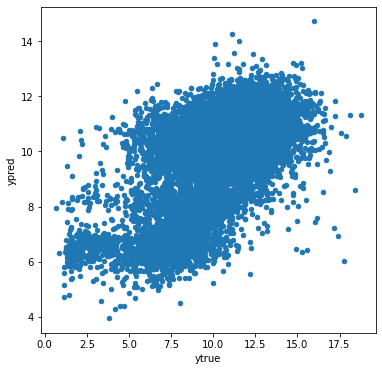

In [30]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [17]:
df_eval2.to_csv('../output/oof_kronecker_epi_AA.csv', index=False)

In [18]:
!ls -lh ../output/oof_kronecker*

-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 ../output/oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 838K Jan 31 22:25 ../output/oof_kronecker_dominant.csv
-rw-r--r-- 1 igorf samuelbf 839K Feb  1 15:47 ../output/oof_kronecker_epi_AA.csv
